# Прогнозирование оттока клиентов телеком-компании

 
<b> Цель проекта: </b>  
Научиться прогнозировать отток клиентов оператора связи с целью их удержания: если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 

<b> Задача: </b>   
Разработать модель машинного обучения для предсказания ухода пользователя.   
Метод обучения с учителем, задача бинарной классификации.
Метрика качества AUC-ROC должна быть не менее 0.85.

<b> Объект исследования: </b>   
Персональные данные о клиентах, информация об их тарифах и договорах.

## План проекта

1. Загрузка и знакомство с данными

2. Подготовка данных   
    2.1. Создание целевого признака Churn  
    2.2. Корректировка типов данных: BeginDate, EndDate, TotalCharges, SeniorCiitizen    
    2.3. Новый признак Tenure - длительность обслуживания  
    2.4. Объединение таблиц, заполнение пропусков   
    2.5. Новый признак number_services - количество услуг
    
3. Исследовательский анализ данных  
    3.1. Анализ признаков: даты, численные, категориальные, целевой признак  
    3.2. Корреляционный анализ   
    3.3. Портрет ушедшего клиента  

4. Предобработка данных для моделирования  
    4.1. Первичный отбор обучающих признаков  
    4.2. Подготовка выборок  
    4.3. Кластеризация для создания нового признака

5. Моделирование. Исследование нескольких алгоритмов машинного обучения  
    5.1. Baseline   
    5.2. LogisticRegression   
    5.3. RandomForestClassifier и ExtraTrees  
    5.4. CatBoostClassifier  

6. Тестирование лучшей модели и анализ результатов  
    6.1. Изучение важности признаков 
    
8. Выводы и резюме

## Импорт библиотек

In [1]:
# библиотека кофээфициент кореляции фи
!pip install phik
# установка библиотеки для кодирования TargetEncoder
!pip install category_encoders
# библиотека важность признаков
!pip install shap

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

# для коэффициента корреляции фи 
import phik
from phik.report import plot_correlation_matrix

from scipy import stats as st
from scipy.stats import shapiro

# деление на выборки
from sklearn.model_selection import train_test_split

# масштабирование и кодирование
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder

# кластеризация
from sklearn.cluster import KMeans

# создание константной модели
from sklearn.dummy import DummyClassifier

# модели 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.decomposition import PCA

# модель градиентный бустинг из библиотеки catboost
import catboost as cb

# метрика классификации, матрица ответов
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score

# подбор гипрепараметров
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_predict

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# матрица ответов
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# скрыть предупреждения
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display_html 
import shap

In [2]:
# зададим переменную с начальным состоянием генератора случайности 
RANDOM_STATE = 140823

In [3]:
# настроим отображение таблиц
# убрать ограничение на количество отображаемых столбцов
pd.options.display.max_columns = None
# 2 цифры после запятой
pd.options.display.precision = 2

## Загрузка и знакомство с данными

Известно, что оператор связи предоставляет телефонную связь и интернет-услуги.   

Предоставленные данные состоят из файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре
- `personal_new.csv` — персональные данные клиента
- `internet_new.csv` — информация об интернет-услугах
- `phone_new.csv` — информация об услугах телефонии.

Информация о договорах актуальна на 1 февраля 2020.

Загрузим и изучим датасеты

In [4]:
# возможные пути расположения файла
server_path = '/datasets/'  
local_path = 'datasets/'

# проверка, какой путь существует
if os.path.exists(server_path):
    path = server_path
    print('server path')
elif os.path.exists(local_path):
    path = local_path
    print('local path')
else:
    print('Неправильно указан путь к файлу')
    
    
# загружаем таблицы
df_contract = pd.read_csv(path + 'contract_new.csv')
df_personal = pd.read_csv(path + 'personal_new.csv')
df_internet = pd.read_csv(path + 'internet_new.csv')
df_phone = pd.read_csv(path + 'phone_new.csv')

local path


In [7]:
# функция для знакомства с содержимым датасета
def df_info(df):
    # вывод первых пяти строк
    display(df.head())
    print('---------------')
    # пропуски и типы данных
    display(df.info())
    print('---------------')
    # дубликаты
    print('Полные дубликаты: ', df.duplicated().sum())
    print('Дубликаты в CustomerID: ', df["customerID"].duplicated().sum())

### Датасет с информацией о договоре Contract:

In [8]:
df_info(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

---------------
Полные дубликаты:  0
Дубликаты в CustomerID:  0


Датасет Contract состоит из 7043 объектов, которые представляют собой информацию о договоре с клиентом:
- `customerID` - идентификатор клиента
- `BeginDate` - дата начала пользования услугами
- `EndDate` – дата окончания пользования услугами. "No" - если клиент продолжает обслуживание
- `Type` – тип оплаты: ежемесячный, годовой и тд
- `PaperlessBilling` – безналичный расчет
- `PaymentMethod` – способ оплаты
- `MonthlyCharges` – ежемесячные траты на услуги
- `TotalCharges` – всего потрачено денег на услуги

Пропусков и дубликатов нет.  

**√**  Для анализа заменим типы данных:
- BeginDate, EndDate - на datetime
- TotalCharges - на float


###  Датасет с персональными данными клиента Personal:

In [9]:
df_info(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

---------------
Полные дубликаты:  0
Дубликаты в CustomerID:  0


Также имеем 7043 уникальных идентификаторов клиентов с персональной информацией о каждом:
- `gender` - пол
- `SeniorCitizen` - наличие пенсионного статуса по возрасту
- `Partner` - наличие супруга(и)
- `Dependents` - наличие иждевенцев

Признак SeniorCitizen имеет численный формат, по значению должен относиться к категориальному. Проанализируем тип данных при подготовке.

###  Датасет с информацией об интернет-услугах Internet:

In [10]:
df_info(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

---------------
Полные дубликаты:  0
Дубликаты в CustomerID:  0


Датасет с информацией об интернет-услугах состоит из уникакальных 5517 строк, пропуски отсутствуют. 
- `InternetService` - интернет-подключение, может быть двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic).
- `OnlineSecurity` - блокировка небезопасных сайтов
- `OnlineBackup` - облачное хранилище файлов для резервного копирования данных
- `DeviceProtection` - антивирус
- `TechSupport` - выделенная линия технической поддержки
- `StreamingTV` - стриминговое телевидение	
- `StreamingMovies` - каталог фильмов
 
Предполагаем, что меньшее количество объектов объясняется тем, что не все клиенты используют интернет-услуги (только телефонию). Считаем, что пользователи, не попавшие в этот датасет, имеют во всех-интернет услугах значение "No"

###  Датасет с информацией об услугах телефонии Phone:

In [11]:
df_info(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

---------------
Полные дубликаты:  0
Дубликаты в CustomerID:  0


Датасет с услугой стационарной телефонной связи состоит из 6361 объекта и одного признака помимо идентификатора клиента: 

- `MultipleLines` – возможность подключение телефонного аппарата к нескольким линиям одновременно

Аналогично предыдущему считаем, что какая-то часть пользователей не использует телефонию (только интернет-услуги). При объединении таблиц будет корректно создать новый признак с указанием, подключена ли услуга телефонии: "Yes" - для пользователей из этой таблицы и "No" для остальных.

---
Мы загрузили и познакомились с предоставленными для исследования данными:   
4 датасета с информацией о договорах, клиентах, услугах телефонии и интернет-услугах. Всего имеем 7043 объекта - пользователей услугами связи. Данные полные, без пропусков и дубликатов. Часть клиентов пользуется только услугами телефонии или интернета.

На этом этапе определили, как нужно подготовить данные для дальнейшего исследования:
 
✔️  Изменить типы данных для признаков с датами `BeginDate`, `EndDate` и одного из двух числовых `TotalCharges`.

✔️ На основе признака с датой окончания пользования услугой `EndDate` создать столбец с целевым признаком.

✔️ Создать новый признак - срок действия договора `tenure`

✔️ Объединить все датасеты в один, разбераться с ожидаемыми пропусками.

## Подготовка данных для анализа


### Создание целевого признака `Churn` - уход клиента
На основе признака с датой окончания пользования услугой `EndDate` мы создадим столбец с **целевым признаком** `Churn`, в котором будет два класса:
- `0` - клиент остаётся клиентом банка, если указано "No"
- `1` - клиент ушёл, если указана дата

In [17]:
# создаём новый столбец churn с двумя вариантвми 0 и 1
df_contract['Сhurn'] = df_contract['EndDate'].apply(lambda x: 0 if x == "No" else 1)
# проверка
df_contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Сhurn
150,3780-YVMFA,2019-06-01,No,Month-to-month,Yes,Electronic check,68.55,548.4,0
1507,7427-AUFPY,2015-08-01,No,Two year,No,Credit card (automatic),19.65,1145.99,0
3188,0587-DMGBH,2019-05-01,No,Month-to-month,Yes,Electronic check,49.85,448.65,0
6046,2959-FENLU,2019-05-01,No,Month-to-month,Yes,Credit card (automatic),85.30,767.7,0
5854,7876-BEUTG,2018-11-01,No,Month-to-month,Yes,Mailed check,48.80,739.32,0


### Корректировка типов данных
#### Даты

In [21]:
# изменим тип данных даты начала обслуживания
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])

# зададим дату выгрузки
latest_date = '2020-02-01'

# в EndDate заменим "No" на крайнюю дату
df_contract['EndDate'] = df_contract['EndDate'].apply(lambda x: latest_date if x == "No" else x)
df_contract['EndDate']  = pd.to_datetime(df_contract['EndDate'] )
df_contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Сhurn
2306,7245-NIIWQ,2019-11-01,2020-02-01,Month-to-month,Yes,Electronic check,69.85,215.84,0
1550,9957-YODKZ,2019-08-01,2020-02-01,Month-to-month,Yes,Electronic check,80.80,484.8,0
1623,6035-RIIOM,2015-08-01,2020-02-01,Two year,Yes,Bank transfer (automatic),97.20,5616.22,0
3998,6752-APNJL,2016-08-01,2016-10-01,Month-to-month,No,Mailed check,54.50,114.45,1
1101,4712-UYOOI,2018-06-01,2020-02-01,Month-to-month,No,Electronic check,20.00,400.0,0


####  `TotalCharges` численный

При попытке конвертации получаем ошибку из-за того, что не все значения в столбце являются числами. Найдём такие значения 

In [22]:
# маска для поиска значений без цифр в столбце TotalCharges
totalcharges_contains_digit_mask = df_contract['TotalCharges'].apply(lambda x: any(char.isdigit() for char in x))
# фильтр по маске
df_contract[~totalcharges_contains_digit_mask]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Сhurn
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0


Вот и причина некорректного типа данных - у нескольких клиентов отсутствуют данные о полной сумме затрат. Видим, что это всё новые клиенты (дата начала обслуживания совпадает с датой выгрузки данных) с годовыми типами оплаты, которые еще не успели ничего заплатить.
Таких клиентов всего 11 в датасете. 

С одной стороны мы можем удалить этих клиентов, так как информация о их поведении еще не накопилась. С другой - в новых данных будут также фигурировать такие новые клиенты и модель должна умень их обрабатывать и давать предсказание.

Предлагаю для них задать `TotalCharges` = 0 и далее изменить тип данных на численный float

In [23]:
# заменяем пустые значения на нули в TotalCharges 
df_contract.loc[df_contract[~totalcharges_contains_digit_mask].index, 'TotalCharges'] = 0

# проверяем замену и соответствовали все изменённые значения дате начала обслуживания 2020-02-01
df_contract.loc[df_contract['BeginDate'] == '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Сhurn
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,0,0


In [24]:
# изменяем тип данных на float
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype('float')
# проверка изменения
df_contract['TotalCharges'].dtype

dtype('float64')

#### `SeniorCitizen`  категориальный
Признак SeniorCitizen имеет численный формат данных. По формулировке предполагаем, что признак категориальный

In [25]:
# уникальные значения в столбце
df_personal['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Два варианта значения - признак категориальный. Для удобства дальнейшего анализа сейчас изменим значения по аналогии с остальными данными в таблице на 'Yes'/'No'

In [26]:
df_personal['SeniorCitizen'] = df_personal['SeniorCitizen'].apply(lambda x: "Yes" if x==1 else "No")
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


### Новый признак `Tenure` - срок действия договора
Для обучения модели мы не будем использовать признаки с датами. Возьмём из них наиболее полезную информацию - срок действия договора обслуживания в днях.

In [27]:
# создадим столбец с количеством дней между датой начала и конца обслуживания, преобразуем в int
df_contract['Tenure'] =  (df_contract['EndDate'] - df_contract['BeginDate']).apply(lambda x: x.days)

In [28]:
df_contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Сhurn,Tenure
3737,8601-QACRS,2019-07-01,2020-02-01,Month-to-month,Yes,Mailed check,50.60,354.20,0,215
385,4895-TMWIR,2019-01-01,2020-02-01,Month-to-month,No,Mailed check,19.95,259.35,0,396
3459,6609-MXJHJ,2017-08-01,2020-02-01,Two year,Yes,Mailed check,25.10,783.12,0,914
237,9903-LYSAB,2018-08-01,2020-02-01,Month-to-month,Yes,Electronic check,73.15,1316.70,0,549
1515,1921-KYSAY,2016-09-01,2020-02-01,One year,Yes,Electronic check,68.60,2812.60,0,1248


### Объединение таблиц, устранение пропусков
Перед объединением **добавим в таблицу с телефонией столбец**, который будет обозначать наличие услуги телефонии

In [29]:
#  новый столбец о наличии услуги телефонии
df_phone['Phone'] = 'Yes'

In [30]:
# объединяем 4 таблицы по ID пользователя
df = df_contract.merge(df_personal, on='customerID', how='left')\
                .merge(df_internet, on='customerID', how='left')\
                .merge(df_phone, on='customerID', how='left')

# выведем получившуюся таблицу
df.sample(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Сhurn,Tenure,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Phone
5724,8042-JVNFH,2019-11-01,2020-02-01,Month-to-month,Yes,Mailed check,71.35,214.05,0,92,Male,No,No,No,Fiber optic,No,No,No,No,No,No,No,Yes
3052,5151-HQRDG,2017-01-01,2020-02-01,Month-to-month,Yes,Mailed check,55.05,2077.59,0,1126,Male,No,Yes,No,DSL,Yes,No,No,No,No,No,Yes,Yes
1395,0471-LVHGK,2016-08-01,2019-07-01,One year,Yes,Electronic check,73.00,2555.00,1,1064,Male,No,Yes,No,DSL,No,No,Yes,No,Yes,Yes,Yes,Yes


Для удобства **изменим написание признаков** - преобразуем из верблюжего в змеиный регистр:

In [31]:
# названия признаков отредактируем - преобразуем из верблюжего с змеиный регистр 
# регулярным выражением поставим нижнее подчёркивание перед заглавной буквой кроме первой, после переведём все в строчные
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
# вручную доисправим 
df = df.rename(columns = {'ustomer_i_d':'customer_id', 
                          'ender':'gender', 
                          'streaming_t_v': 
                          'streaming_tv', 'hurn':'churn'})

In [32]:
# проанализируем содержимое объединенной таблицы
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn              7043 non-null   int64         
 9   tenure             7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   object        
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

Как и ожидалось, в признаках с услугами при объединении появились пропуски, которые означают, что клиент не использует их. 
**Заполним образовавшиеся пропуски выражением "No service"**, чтобы отметить, что клиент вообще не использует один из двух типов услуг (интернет, телефония).

In [33]:
# заполнение пропусков
df = df.fillna('No service')

# проверка результата
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churn              7043 non-null   int64         
 9   tenure             7043 non-null   int64         
 10  gender             7043 non-null   object        
 11  senior_citizen     7043 non-null   object        
 12  partner            7043 non-null   object        
 13  dependents         7043 non-null   object        
 14  internet

**Назначим `customer_id` индексом**

In [34]:
# назначим customer_id индексом
df = df.set_index('customer_id')
df.head(2)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,tenure,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,phone
customer_id,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No service,No service
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,Yes


### Новый признак `number_services` - количество подключённых услуг
Забегая немного вперёд, перед анализом добавим еще один признак с общим количеством услуг, которые использует клиент

In [35]:
# список признаков с услугами
services_list = ['internet_service', 'online_security', 'online_backup', 
            'device_protection', 'tech_support', 'streaming_tv', 
            'streaming_movies', 'multiple_lines', 'phone']

# создадим признак количество услуг
df['number_services'] = df[services_list].applymap(lambda x: x not in ['No', 'No service']).sum(axis=1)

# проверим, что получилось 
df.sample(3)

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,tenure,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,phone,number_services
customer_id,,,,,,,,,,,,,,,,,,,,,,,
9938-ZREHM,2017-01-01,2020-02-01,One year,No,Mailed check,72.10,2881.12,0,1126,Female,No,Yes,No,DSL,No,Yes,No,Yes,No,Yes,Yes,Yes,6
2662-NNTDK,2014-09-01,2020-02-01,One year,No,Credit card (automatic),24.80,1692.60,0,1979,Male,No,No,No,No service,No service,No service,No service,No service,No service,No service,Yes,Yes,2
4007-NHVHI,2015-06-01,2020-02-01,Month-to-month,Yes,Electronic check,96.85,5423.60,0,1706,Female,Yes,No,No,Fiber optic,Yes,Yes,No,No,No,Yes,Yes,Yes,6


---
Мы подготовили для исследовательского анализа один общий датафрейм с данными из 4-х предоставленных источников .  

✔️ Добавлены новые признаки:  
- `churn` - уход клиента (целевой)  
- `tenure` - срок обслуживания  
- `phone` - наличие услуги телефонии
- `number_services` - количество подключенных услуг

✔️ Изменили типы данных для признаков с датам, `total_charges` на float, `senior_sitizen` на object.

✔️ В признаке с полными затратами `tota_charges`  пустые значения для новых клиентов, дата начала обслуживания которых совпадает с датой выгрузки датасета 2020-02-01, заменены на нули. Модель должна уметь обрабатывать записи с новыми клиентами.

✔️ Назначили `customer_id` в качестве индекса. 

✔️ Образовавшиеся при объединении пропуски в услугах заполнили "No service", что означает, что клиент не использует услугу.  



## Исследовательский анализ данных
### Анализ  признаков

#### Признаки с датами
Посмотрим за какой период данные и как распределены во времени

In [36]:

print('Период дат начала обслуживания: ', df['begin_date'].dt.date.min(), "-", df['begin_date'].dt.date.max())
print('Период дат прекращения обслуживания: ', df['end_date'].dt.date.min(), '-', df['end_date'].dt.date.max())
print('Полный период данных:', df['begin_date'].max() - df['begin_date'].min())

Период дат начала обслуживания:  2013-10-01 - 2020-02-01
Период дат прекращения обслуживания:  2014-06-01 - 2020-02-01
Полный период данных: 2314 days 00:00:00


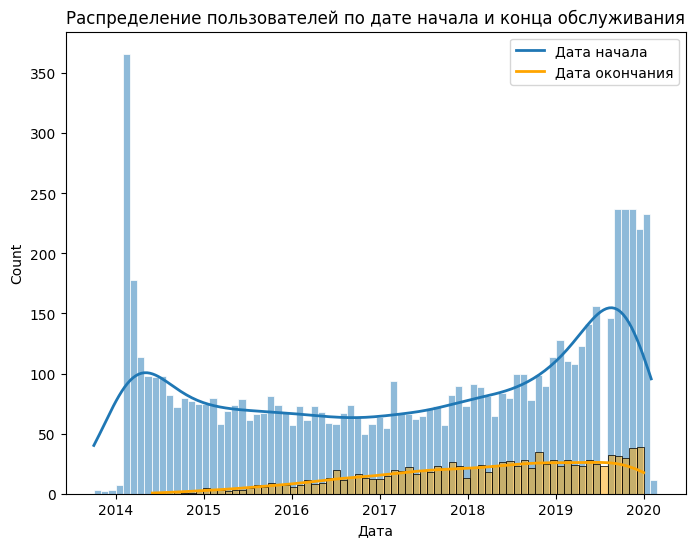

In [37]:
# гистограммы распределение объектов по датам начала и конца обслуживания
plt.figure(figsize=(8, 6))
sns.histplot(data=df['begin_date'], 
             binwidth=30, kde=True, edgecolor='white', line_kws={'linewidth': 2})

sns.histplot(data=df[df['end_date']<latest_date]['end_date'], 
             binwidth=30, kde=True, line_kws={'linewidth': 2}, color='orange')
plt.title('Распределение пользователей по дате начала и конца обслуживания')
plt.xlabel('Дата')
plt.legend(['Дата начала', 'Дата окончания'])
plt.show()

- Данные распределены по всему периоду 10.2013 - 01.2020. 
- В 2019 году заметный рост новых клиентов
- Количество уходящих клиентов увеличивается постепенно и медленно, начиная с 06.2014

#### Числовые признаки
Проанализируем распределение числовых признаков

,count,mean,std,min,25%,50%,75%,max
monthly_charges,7043.0,64.76,30.09,18.25,35.50,70.35,89.85,118.75
total_charges,7043.0,2115.31,2112.74,0.00,436.75,1343.35,3236.69,9221.38
churn,7043.0,0.16,0.36,0.00,0.00,0.00,0.00,1.00
tenure,7043.0,898.56,683.13,0.00,276.00,761.00,1461.00,2314.00
number_services,7043.0,4.15,2.31,1.00,2.00,4.00,6.00,9.00


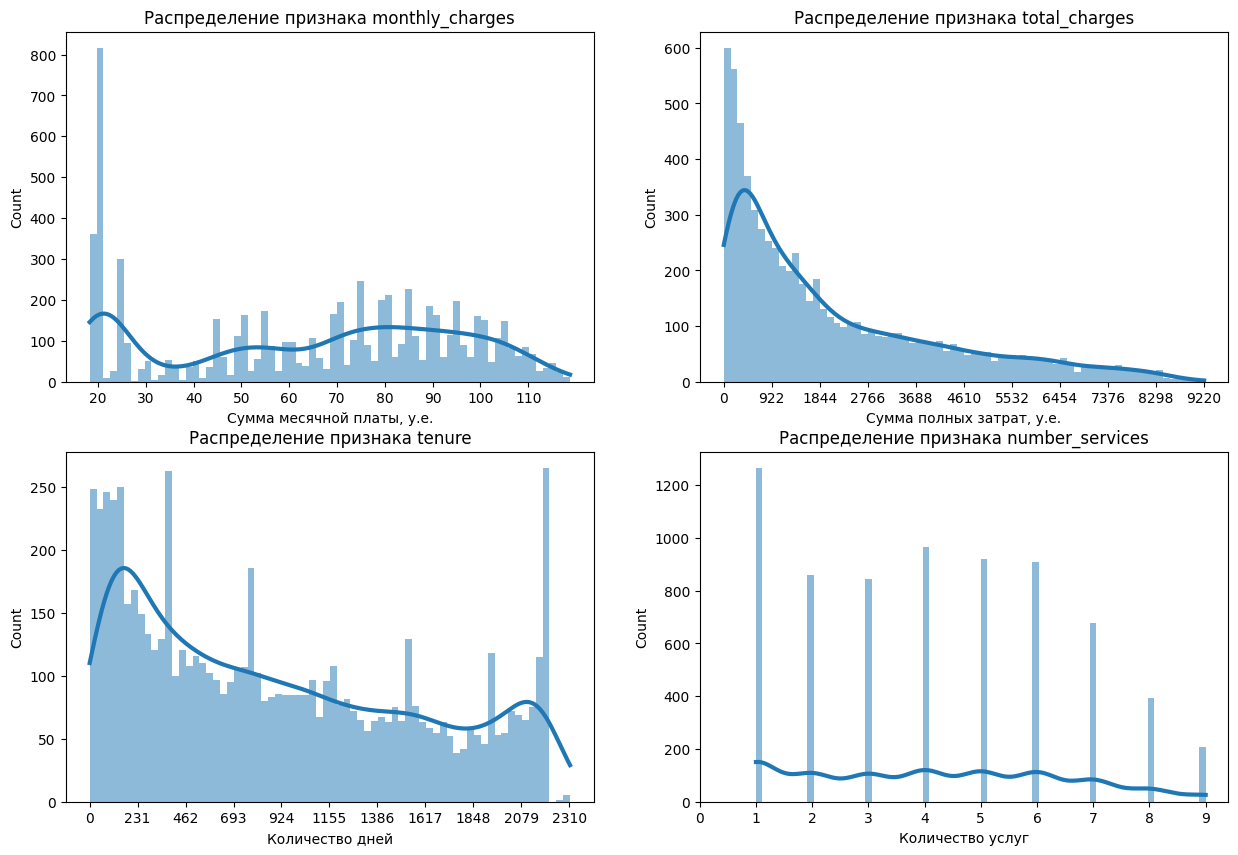

In [38]:
# статистики
display(df.describe().T)

# гистограммы распределения
fig = plt.figure(figsize=(15, 10))
for i, col, label in zip(range(4), 
                         ['monthly_charges', 'total_charges', 'tenure', 'number_services'],
                         ['Сумма месячной платы, у.е.', 'Сумма полных затрат, у.е.', 'Количество дней', 'Количество услуг']):
    fig.add_subplot(2, 2, i+1)
    sns.histplot(df[col], bins=70, kde=True, edgecolor=None, line_kws={'linewidth': 3})
    plt.xticks(range(round(df[col].min()/10)*10, 
                     round(df[col].max() + 1), 
                     round((df[col].max() - df[col].min())/10)))
    plt.xlabel(label)
    plt.title('Распределение признака ' + col)

Проверим на аномальные значения с помомощью ящиков с усами

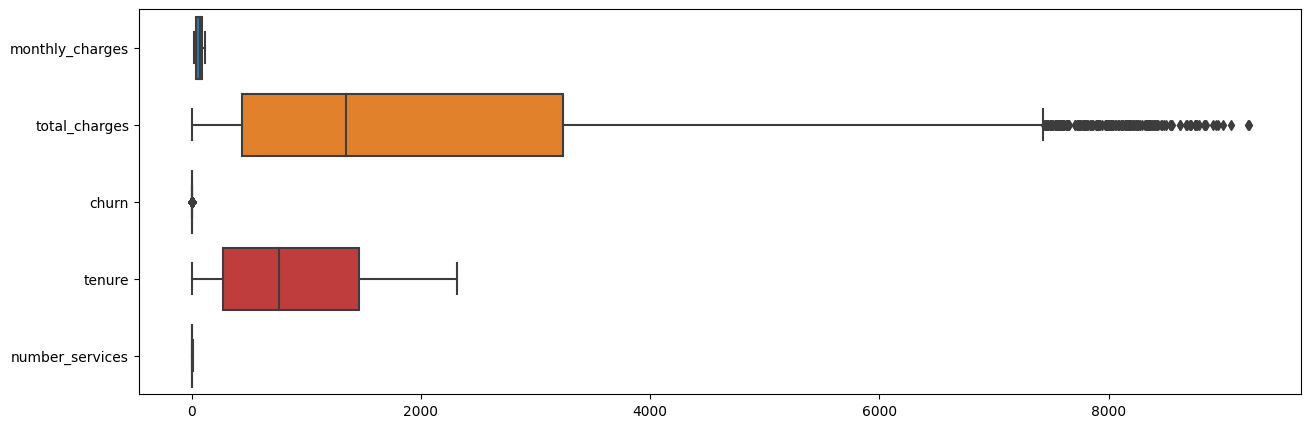

In [39]:
# ящики с усами для численных признаков
plt.figure(figsize=(15, 5))
sns.boxplot(data=df, orient='h')
plt.show()

"Выбросы" выявлены только в признаке с полными тратами. Посмотрим объекты с крайними значениями признака

In [40]:
# фильтр для самых высоких значений total_charges
df[df['total_charges']>8500]

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churn,tenure,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,phone,number_services
customer_id,,,,,,,,,,,,,,,,,,,,,,,
3520-FJGCV,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),112.60,8755.78,0,2191,Male,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,9
6859-QNXIQ,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),113.10,8957.52,0,2191,Female,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,9
2499-AJYUA,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),110.80,8775.36,0,2191,Female,Yes,Yes,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,8
6007-TCTST,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),115.80,8837.86,0,2191,Female,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,9
9127-FHJBZ,2014-02-01,2020-02-01,Two year,Yes,Electronic check,114.00,8536.32,0,2191,Male,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,9
2388-LAESQ,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),114.85,8765.35,0,2191,Female,Yes,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,9
9637-CDTKZ,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),114.10,8708.11,0,2191,Male,No,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,9
6650-BWFRT,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),117.15,8687.84,0,2191,Female,No,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,9
7055-JCGNI,2014-04-01,2020-02-01,Two year,Yes,Credit card (automatic),111.95,8620.15,0,2132,Female,No,No,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,9


Все клиенты с самыми высокими значениями общих затрат обслуживаются в компании с самого начала периода и имеют самые высоки месячные платы и количество используемых услуг. Это не выбросы.

- Целевой признаки `churn` по смыслу категориальный, его рассмотрим позже
- Месячные трата лежит в диапазоне 18 - 119, в среднем 30 у.е. Самая частая встречающаяся трата - минимальная в районе 20 у.е. - скорее всего стоимость одной услуги. Далее падение и от 45 частота появления увеличивается - скорее всего клиенты, использующие более двух услуг. Везде пики вокруг округленных до пяти у.е. значений.
- Полная трата распределена в диапазоне 0 - 9221, в среднем 2115. Нулевые значения у новых клиентов. Пик в минимальных значениях и далее постепенное уменьшение - закономерно, так как зависит от длительности обслуживания клиента.

- Длительность обслуживания клиента распределена от 0 дней до 2314. Максимум соответствует продолжительности всего периода в датасете (около 6 лет), то есть клиент с самого предположительно начала появления услуг в компании пользуется ими до сих пор.  
Высокая частота в значениях до полугода, что может объясняться ростом новых клиентов в последний год.  
Есть пики, возможно были акционные периоды, в которые активнее шло привлечение новых клиентов.  
Ближе к максимуму пик - клиенты, привлечённые в период появления услуг у компании.
- Больше всего клиентов с 1 услугой, среди остальных преобладает 4-6 услуг 


#### Категориальные признаки

In [41]:
# создадим список признаков с типом данных object - категориальных
cat_features = df.select_dtypes(include=['object']).columns.to_list()

# для каждого напечатаем уникальные значения с количеством и долей от общего в процентах
for col in cat_features:
    
    value_counts = df[col].value_counts()
    total_count = len(df[col])
    percentages = (value_counts / total_count) * 100
    result = pd.DataFrame({'Количество:': value_counts, '%:': round(percentages, 1)})

    print('--',col,':', '------')
    print(result)
    print()

-- type : ------
                Количество:    %:
Month-to-month         3875  55.0
Two year               1695  24.1
One year               1473  20.9

-- paperless_billing : ------
     Количество:    %:
Yes         4171  59.2
No          2872  40.8

-- payment_method : ------
                           Количество:    %:
Electronic check                  2365  33.6
Mailed check                      1612  22.9
Bank transfer (automatic)         1544  21.9
Credit card (automatic)           1522  21.6

-- gender : ------
        Количество:    %:
Male           3555  50.5
Female         3488  49.5

-- senior_citizen : ------
     Количество:    %:
No          5901  83.8
Yes         1142  16.2

-- partner : ------
     Количество:    %:
No          3641  51.7
Yes         3402  48.3

-- dependents : ------
     Количество:    %:
No          4933  70.0
Yes         2110  30.0

-- internet_service : ------
             Количество:    %:
Fiber optic         3096  44.0
DSL                 2421

- 3 признака, связанные со способом оплаты: 
    - 3 вида типа оплаты: два годовых, один ежемесячный
    - 4 способа проведения оплаты: чек по почте, электронный чек, автоматические банковский перевод или списание с кредитной карты
    - наличный или безналичный расчёт
- В персональных данных по 2 варианта ответа Yes/No
- Во всех услугах по 3 варианта: Yes, No и No service - когда клиент пользуется только телефонией или только инттернет-услугами.   
В интернет-подключении вместо Yes указана технология DSL или Fiber optic.

#### Целевой признак


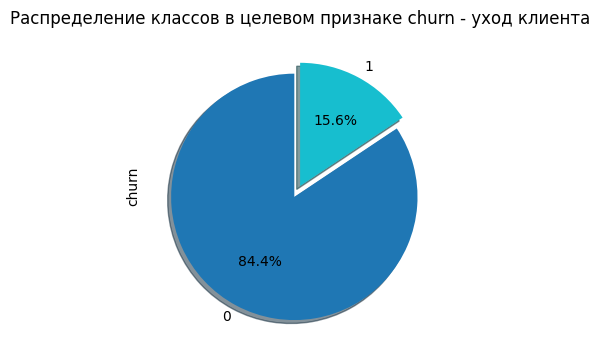

,count,mean,std,min,25%,50%,75%,max
churn,7043.0,0.16,0.36,0.0,0.0,0.0,0.0,1.0


In [42]:
# диаграмма распределения классов в целевом признаке
plt.figure(figsize=(5, 4))

df['churn'].value_counts().plot(kind='pie', 
                                shadow=True, 
                                startangle=90, 
                                explode = (0.1, 0),
                                autopct='%1.1f%%', 
                                cmap='tab10').set_title('Распределение классов в целевом признаке churn - уход клиента')
plt.show()
df['churn'].describe().to_frame().T

Классификация бинарная с дисбалансом классов - всего 16% от всех клиентов в датасете перестало пользоваться услугами компании.  
Для того, чтобы учесть дисбаланс при обучении и оценке модели мы будем использовать встроенный в модели гиперпараметр class_balanced.


### Корреляционный анализ
Сначала оценим коэффициенты корреляции Спирмена для чиссленных признаков, чтобы посмотреть на наличие монотонной зависимости 

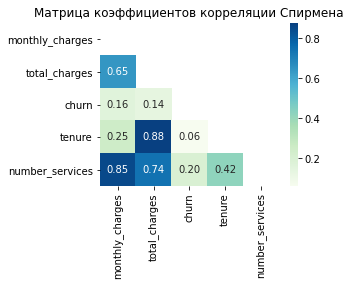

In [37]:
# коэффициент корреляции Спирмена для численных признаков (не распределены нормально)
spearman_corr_matrix = df.corr(method='spearman')
# тепловая матрица
plt.figure(figsize=(4, 3))
matrix_mask = np.triu(spearman_corr_matrix) # маска, чтобы убрать вернюю треугольную часть с симметричными данными
sns.heatmap(spearman_corr_matrix, annot=True, cmap='GnBu', fmt=".2f",
            mask=matrix_mask)
plt.title('Матрица коэффициентов корреляции Спирмена')
plt.show()

- Ожидаемая зависимость длительности обслуживания и полных затрат.
- Корреляция средней силы между ежемесячной платой и полными затратами

Теперь посмотрим на коэффициенты сопряженности $\phi_K$, которые покажут не только линейные зависимости во всём наборе данных

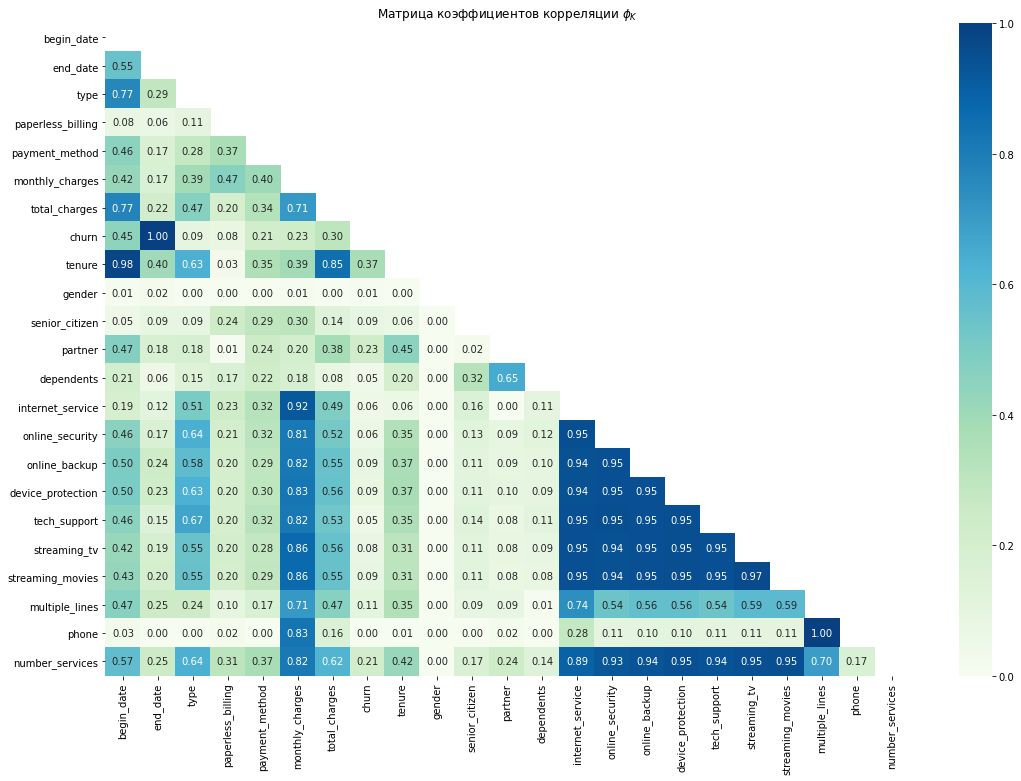

In [38]:
# матрица коффициентов корреляции фи - показывает также нелинейные зависимости для всех признаков
phi_matrix = df.phik_matrix(
                    interval_cols=['monthly_charges', 'total_charges', 'churn', 'tenure', 'number_services'])

plt.figure(figsize=(18, 12))
# маска для отображения нижнего треугольника
phi_matrix_mask = np.triu(np.ones_like(phi_matrix, dtype=bool))

sns.heatmap(phi_matrix, 
            annot=True, cmap='GnBu', fmt=".2f",
           mask=phi_matrix_mask)
plt.title('Матрица коэффициентов корреляции $\phi_K$')
plt.show()

Высокие значения коэффициента корреляции получены:
- У churn и tenure с датами, так как они получены из дат. Даты не будем использовать для обучения.
- Все интернет-услуги высоко коррелируют между собой. Скорее всего, чаще берутся пакетом.
- Корреляция месячной оплаты и наличия услуг. Месячная стоимость зависит от количества услуг.
- Ожидаемо: корреляция полной суммы и срока обслуживания.
- Интересно: тип оплаты с датой начала обслуживания, интернет-услугами и количеством услуг. Далее проверим, возможно в начале предлагался выгодный пакет услуг с условием заключения годового контракта. 
- Коррелируют месячная и полная платы.
- Странно, что не коррелирелируют наличие безналичной оплаты и способ оплаты

Перепроверим статистическую значимость полученных зависимостей между парами признаков.  
Возьмём уровень значимости 5%

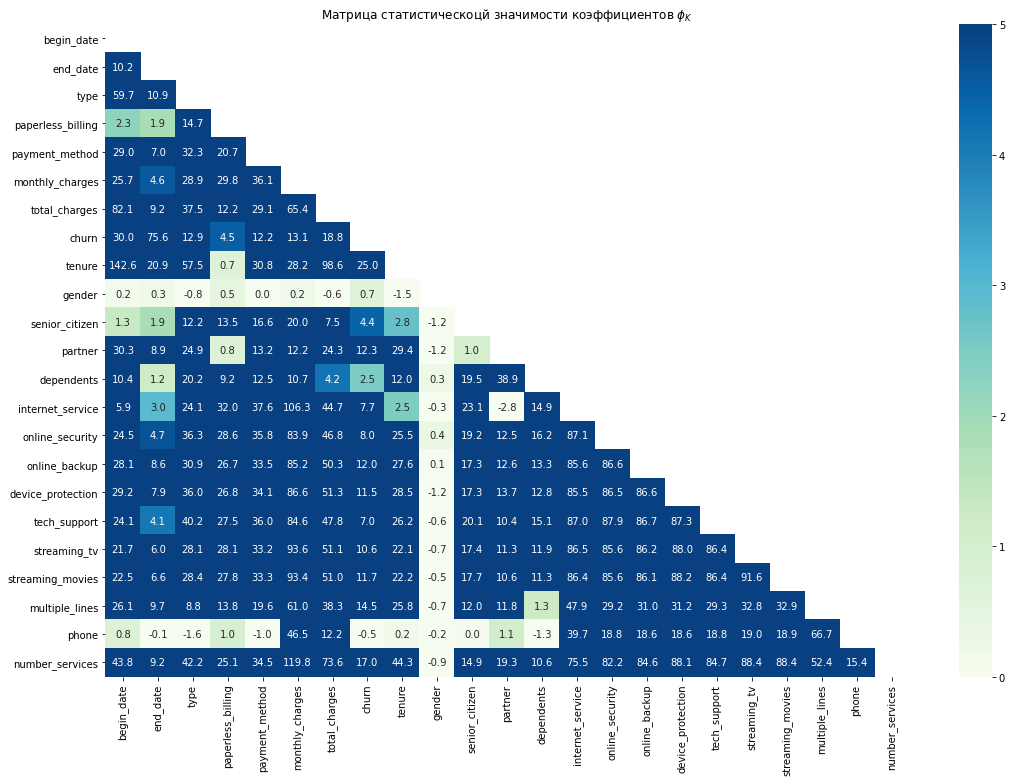

In [39]:
# матрица статистической значимости зависимости между парами признаков
significance_matrix_phi = df.significance_matrix(
   interval_cols =['monthly_charges', 'total_charges', 'churn', 'tenure', 'number_services'])

# тепловая карта
plt.figure(figsize=(18, 12))
sns.heatmap(significance_matrix_phi, 
            annot=True, cmap='GnBu', fmt=".1f",
            vmin=0, vmax=5,
            mask=phi_matrix_mask)
plt.title('Матрица статистическоцй значимости коэффициентов $\phi_K$')
plt.show()

Все описанные взаимосвязи имеют статистическую значимость.

Дополнительно посмотрим с чем связана корреляция типа оплаты с датами начала и конца обслуживания и количеством услуг.

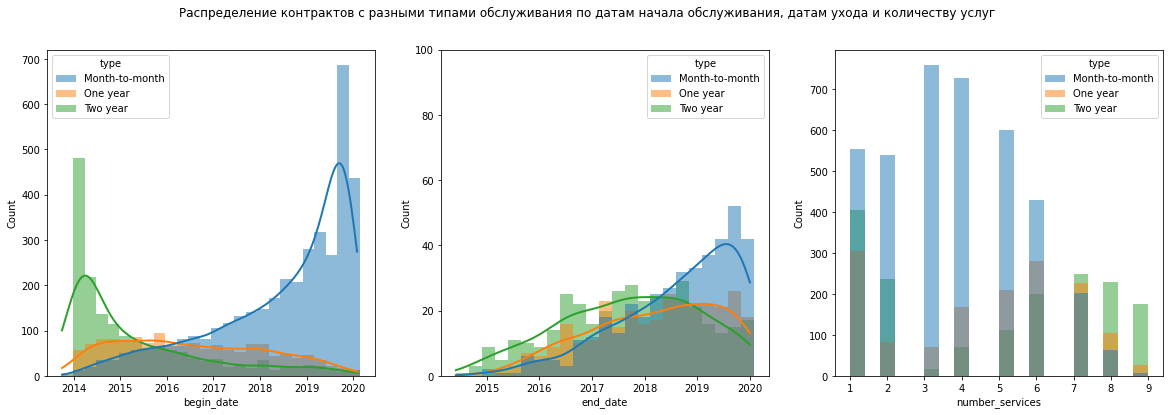

In [40]:
# гистограммы с делением по типу оплаты
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(data=df, x='begin_date', hue='type',binwidth=90, kde=True, edgecolor=None, line_kws={'linewidth': 2},
            ax=axs[0])

sns.histplot(data=df[df['end_date'] < latest_date], binwidth=90, x='end_date', hue='type',kde=True, 
             edgecolor=None, line_kws={'linewidth': 2}, hue_order=['Month-to-month', 'One year', 'Two year'],
            ax=axs[1]).set_ylim((0,100))

sns.histplot(data=df, x='number_services', hue='type', edgecolor=None,
            ax=axs[2])

plt.suptitle('Распределение контрактов с разными типами обслуживания по датам начала обслуживания, датам ухода и количеству услуг')
plt.show()

- Основная доля подключившихся в первый год клиентов имеет двухлетний тип оплаты, а также однолетний. Допускаем, что заказчик имел специальное предложение в начале периода с такими типами оплаты или невыгодные условия для ежемесячной оплаты
- Ежемесячная плата становилась более популярной постепенно, через 4 года в  2018 году становится преобладающим типом заключенных контрактов.
- Как следствие, первыми уходящими клиентами были клиенты с годовыми типами оплатами,  до конца периода их доля среди уходящих больше, чем в приходящих.
- Высокая доля годовых контрактов среди самых больших значений количества услуг и 1 услуги.

Подтверждается взаимосвязь типа оплаты с датой подключения и количеством услуг. Скорее всего заказчик имеет пакетное предложение с условием годовой оплаты, что активно продвигалось в начале периода


### Портрет ушедшего клиента
Посмотрим подробнее на распределения признаков, разделив клиентов на продолжающих обслуживание и ушедших.  
Первым делом посмотрим даты прихода в зависимости от целевого признака и даты ухода клиентов и параллельно продолжительность обслуживания


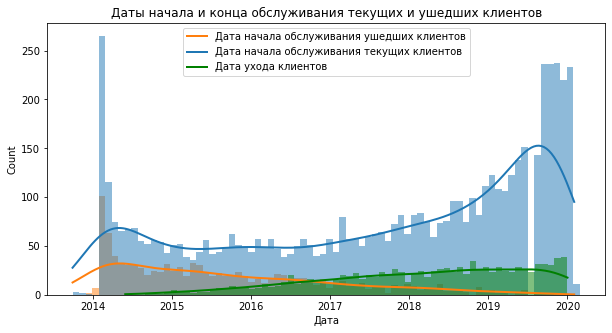

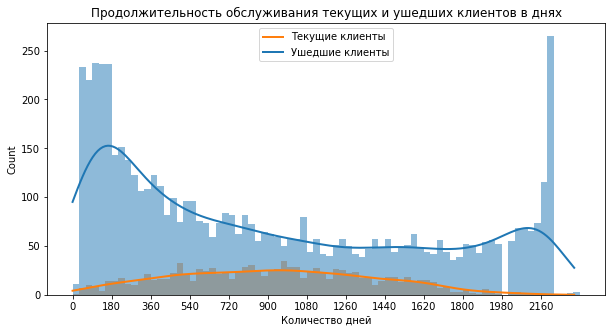

In [41]:
# гистограмма по датам прихода  с делением по целевому признаку
plt.figure(figsize=(10,5))
sns.histplot(df, x='begin_date', 
             binwidth=30, kde=True, edgecolor=None, line_kws={'linewidth': 2},
#              common_norm=False,
#              stat='probability',
             hue='churn')
# гистограмма на том же графике с датами ухода
sns.histplot(df[df['end_date']<latest_date], x='end_date', 
             binwidth=30, kde=True, edgecolor=None, line_kws={'linewidth': 2},
#              common_norm=False,
#              stat='probability',
#              hue='churn', 
             color='g')
plt.legend(['Дата начала обслуживания ушедших клиентов',
            'Дата начала обслуживания текущих клиентов', 
            'Дата ухода клиентов'])
plt.title('Даты начала и конца обслуживания текущих и ушедших клиентов')
plt.xlabel('Дата')

# второй график с гистограммой по дням обсуживания с делением по целевому признаку
plt.figure(figsize=(10,5))
sns.histplot(df, x='tenure', 
             binwidth=30, # корзина = полгода
             kde=True, edgecolor=None, line_kws={'linewidth': 2}, hue='churn')
plt.title('Продолжительность обслуживания текущих и ушедших клиентов в днях')
plt.xlabel('Количество дней')
plt.xticks(range(0, 2200, 180))
plt.legend(['Текущие клиенты', 'Ушедшие клиенты'], loc='upper center')
plt.show()

- Судя по распределению по датам начала и конца обслуживания ушедших клиентов, а также их длительности обслуживания, вероятность ухода повышается приблизительно через полтора-два года после заключения контракта.
- При достижении 4,7 лет обслуживания вероятность ухода становится наиболее низкой.


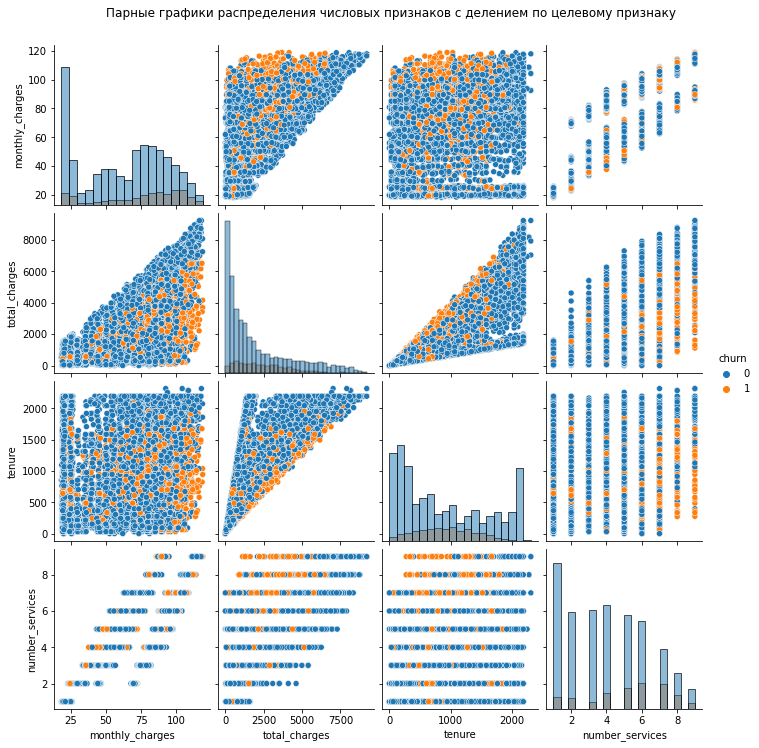

In [42]:
# попарные графики числовых признаков с делением по целевому признаку
sns.pairplot(df, hue='churn', diag_kind='hist')
plt.title('Парные графики распределения числовых признаков с делением по целевому признаку', x=-1, y=4.3)
plt.grid()
plt.show()

- Критичный для ухода период обслуживания ~ 1 - 4,7 лет
- Вероятность ухода клиента заметно увеличивается, если он имеет высокую месячную плату (в рамках критичного периода)
- Также подтверждается, что после ~4,7 лет обслуживания и, как следствие, при достижении ~7 тыс. у.е. полных трат уход клиента наиболее маловероятен.
- Вероятность ухода выше у клиентов с 7-9 услугами.
- Интересно: ежемесячная плата пропорционально растёт при увеличении количества услуг, но есть 2 параллельных кластера, видимо с более дешёвыми и более дорогими услугами.

Оценим статистики распределения числовых признаков по классам.

In [43]:
# выведем статистики распределений для двух классов по отдельности
print('Текущие клиенты:')
display(df[df['churn']==0].describe().T)
print('Ушедшие клиенты:')
display(df[df['churn']==1].describe().T)

Текущие клиенты:


,count,mean,std,min,25%,50%,75%,max
monthly_charges,5942.0,62.76,29.84,18.25,30.06,69.2,87.24,118.60
total_charges,5942.0,2067.87,2193.90,0.00,374.35,1192.8,3173.84,9221.38
churn,5942.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00
tenure,5942.0,893.68,716.96,0.00,245.00,702.0,1523.00,2314.00
number_services,5942.0,3.95,2.28,1.00,2.00,4.0,6.00,9.00


Ушедшие клиенты:


,count,mean,std,min,25%,50%,75%,max
monthly_charges,1101.0,75.55,29.12,18.40,56.15,84.20,99.50,118.75
total_charges,1101.0,2371.38,1581.86,77.84,1048.05,2139.03,3404.91,7649.76
churn,1101.0,1.00,0.00,1.00,1.00,1.00,1.00,1.00
tenure,1101.0,924.86,458.77,28.00,577.00,915.00,1249.00,2129.00
number_services,1101.0,5.20,2.21,1.00,4.00,6.00,7.00,9.00



Проверим гипотезу: *средняя месячная плата `monthly_charges` текущих и ушедших клиентов различается*.  
Видится, что на признаки с общими тратами и продолжительностью обслуживания сильнее будет влиять повышение прихода новых клиентов в последний год.

```
H_0: месячная плата текущих клиентов = месячная плата ушедших клиентов`
H_a: месячная плата текущих клиентов ≠ месячная плата ушедших клиентов"`
Уровень значимости alpha = 0.05
```

In [43]:
# две выборки разделённые по целевому признаку
current = df[df['churn'] ==0]['monthly_charges']
exited = df[df['churn'] ==1]['monthly_charges']

# вызов метода для проверки двухсторонней гипотезы
results = st.ttest_ind(current, exited, equal_var=False)
# уровень значимости
alpha = 0.05
# p-value  
print(results.pvalue)

# ответ
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.8660383977850398e-38
Отвергаем нулевую гипотезу


Мы отвергаем нулевую гипотезу на уровне значимости 5%. Это подтверждает, что среднее значение ежемесячной платы за услуги отличается между текущими клиентами и ушедшими.

Теперь разберём категориальные признаки, выделим в каждой группе каждого признака ушедших клиентов.

In [46]:
def pie_for_groups_by_churn(col):
    ''' Функция строит круговые диаграммы для каждой группы в категориальном признаке с делением по целевому признаку churn.
        На вход принимает название признака, для которого проводится группировка и строятся диаграммы '''

    # сгруппировать по признаку
    pivot_table = df.pivot_table(index=col, columns='churn', values='begin_date', aggfunc='count')
    
    # создать список классов в признаке по убыванию его доли
    classes_names = pivot_table.sort_values(by=0, ascending=False).reset_index().iloc[:,0].to_list()
    
    # общий график 
    fig, axs = plt.subplots(1, len(classes_names),  figsize=(5*len(classes_names), 5))
    # для каждого класса и его индекса в списке построить круговую диаграмму
    for i, class_name in enumerate(classes_names):
        pivot_table.loc[class_name].plot(kind='pie', 
                                         ax=axs[i],
                                         ylabel='',
                                         shadow=True, 
                                        startangle=90, 
                                        explode = (0.1, 0),
                                        autopct='%1.1f%%', 
                                        cmap='tab20').set_title(f"""{class_name}
{pivot_table.loc[class_name].sum()}  ({round(pivot_table.loc[class_name].sum()/pivot_table.values.sum()*100, 1)}%)""")
        
    plt.suptitle(f'Текущие и ушедшие клиенты в каждой группе признака {col}:', y=0.9)
    fig.legend(['0: Текущие клиенты', '1: Ушедшие клиенты'], bbox_to_anchor=[0.5, 0], loc='lower center', ncol=2)
    fig.tight_layout()  # автоматический расчет отступов
    fig.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)  # настройка отступов вручную
    plt.show()

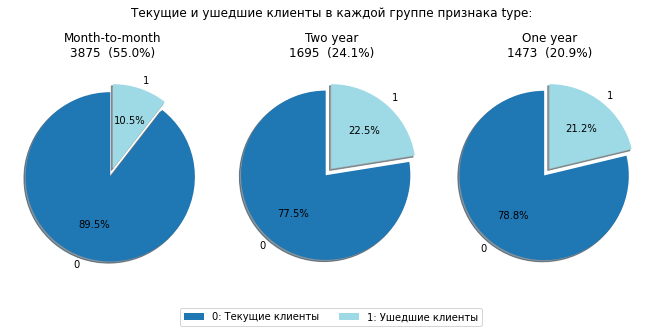

In [47]:
pie_for_groups_by_churn('type')

`PaymentMethod` – способ оплаты  
- Доля ушедших больше среди контрактов с годовыми типами оплаты, чем ежемесячным

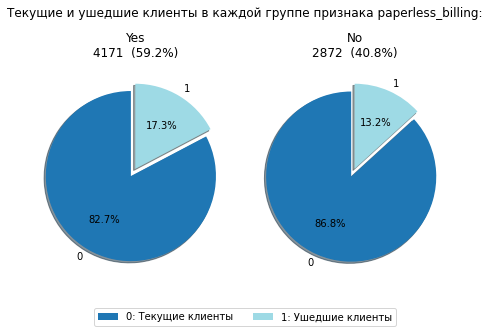

In [48]:
pie_for_groups_by_churn('paperless_billing')

`PaperlessBilling` – безналичный расчет  
- Доля ушедших больше среди пользователей с безналичной оплатой

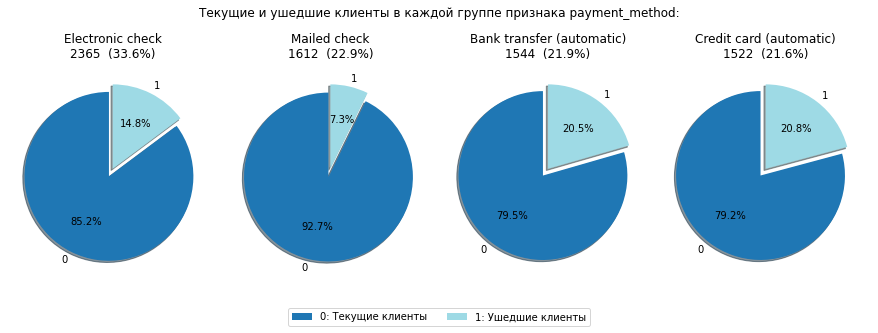

In [49]:
pie_for_groups_by_churn('payment_method')

`PaymentMethod` – способ оплаты  
- Больше ушедших среди клиентов с автоматическим списанием с банковского счёта или кредитной карты.
- Меньше у использующих получение чека по почте.

В общем уже наблюдаем тенденцию, что доля ушедших выше среди клиентов, использующих более передовые технологии и способы взаимодействия.

Посмотрим распределение в зависимости от пресональных характеристик пользователя.

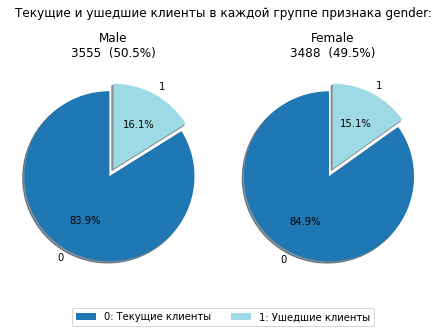

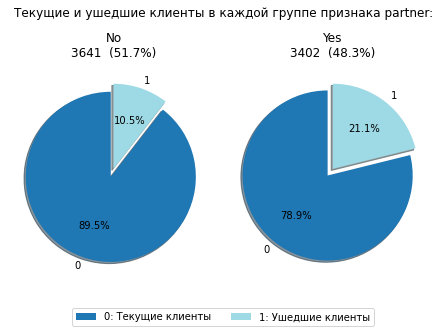

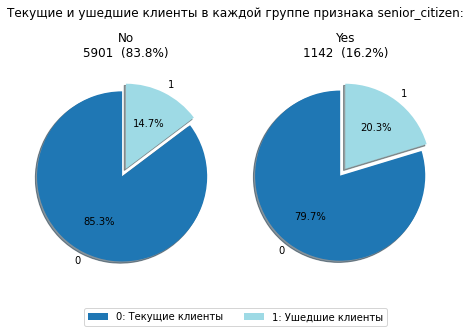

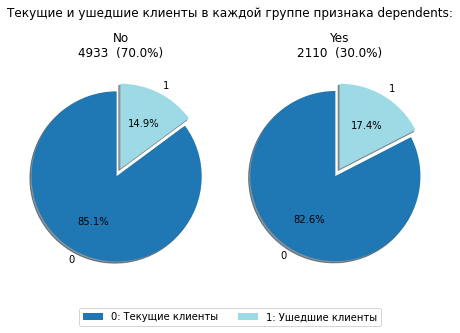

In [50]:
# # диаграммы распределения ушедших клиентов по признакам personal
for col in ['gender', 'partner', 'senior_citizen', 'dependents']:
    pie_for_groups_by_churn(col)

- Нет зависимости поведения от пола. Этот признак удалим
- Вероятность ухода выше среди клиентов, состоящих в браке, являющихся пенсионерами и незначительно у имеющих иждивенцев

Осталось проанализировать услуги

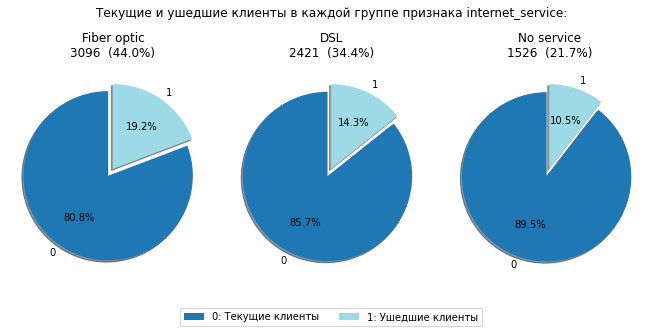

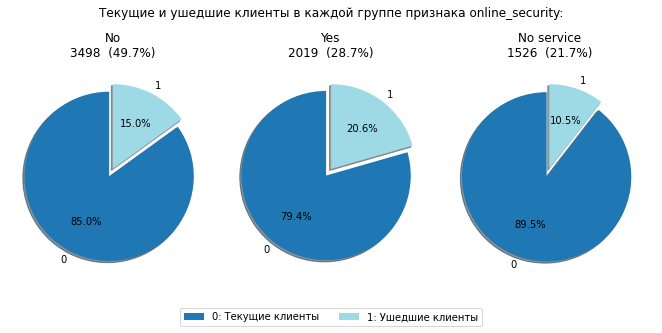

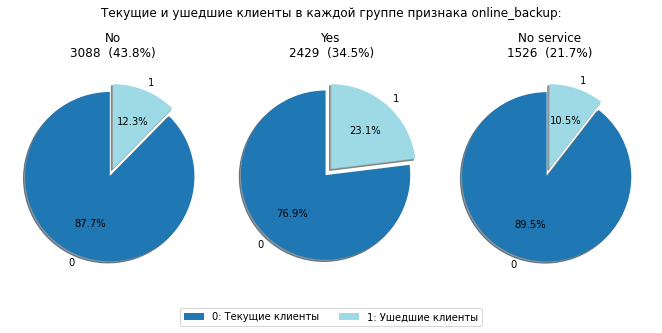

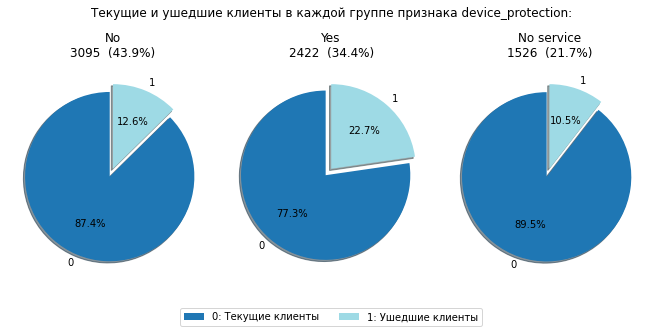

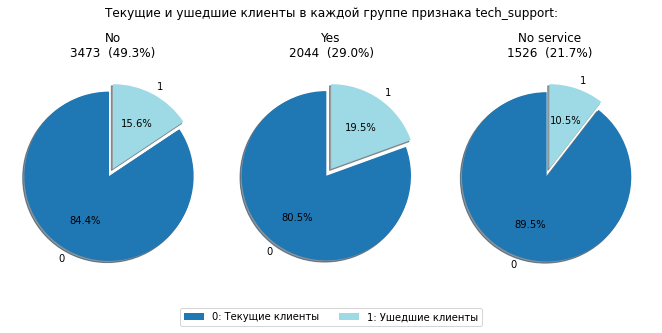

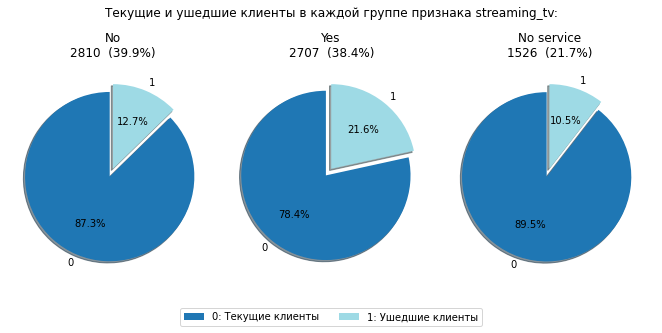

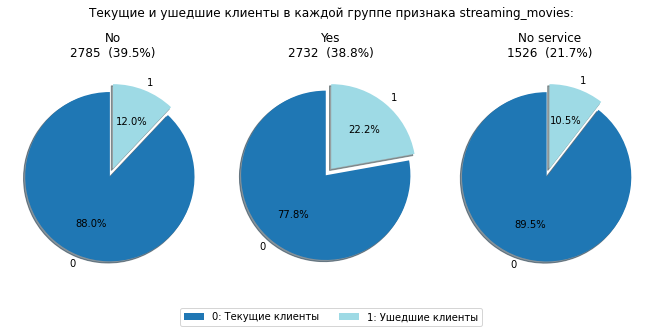

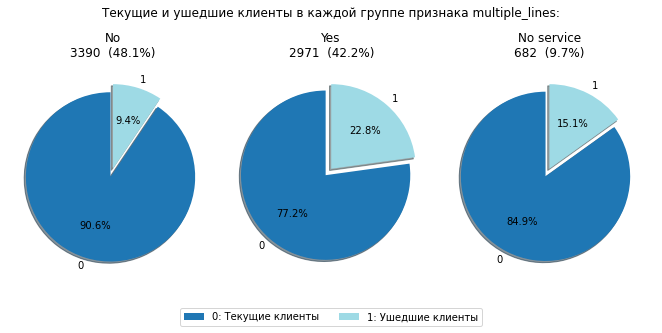

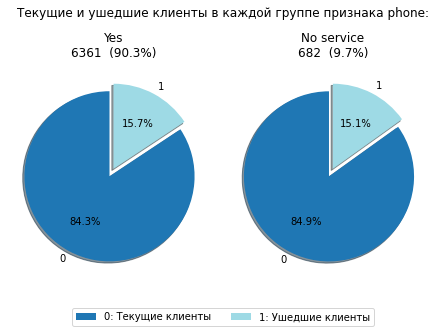

In [51]:
# диагрраммы для всех услуг в списке
for col in services_list:
    pie_for_groups_by_churn(col)

- Общее правило: вероятность ухода выше, если клиент использует услугу. Коррелирует с зависимостью от месячной платы, которая повышается с увеличением количесства услуг.
- Среди использующих Fiber optic интернет-подключение больше ушедших, чем среди DSL. Это также может показывать, что более склонны к уходу клиенты, открытые передовым технологиям и готовые искать более лучшие и качественные условия.
- Наличие услуги телефонии одинаково среди обоих классов

---
**Результаты иследовательского анализа предоставленных данных** 

Общие наблюдения:
- Данные непрерывно распределены по периоду 10.2013 - 01.2020, длительность 2314 дней. Есть клиенты, пользующиеся услугами в течение всего периода.
- В течение 2019 года заметный рост новых клиентов 
- Количество уходящих клиентов увеличивается медленно и постепенно, начиная с 06.2014
- В целевом признаке с уходом клиента два класса,представленных неравномерно - всего 16% от всех пользователей перестало пользоваться услугами компании. Дисбаланс учтём при обучении модели, задавая гмперпараметр class_balanced
- Есть численные линейно-зависимые признаки: полные затраты коррелируют с длительностью обслуживания и ежемесячной тратой. 
- Все интернет-услуги высоко коррелируют между собой, а также с месячной платой. Скорее всего, чаще берутся пакетом.
- В начале периода было больше клиентов с годовыми типами обслуживания.

**Портрет ушедшего клиента**
- Срок обслуживания `tenure` 1 - 4.7 лет
- Относительно высокая ежемесячная плата `monthly_charges`.
- Клиент предпочитает использовать передовые технологии и комфортное обслуживание:
    - интернет-подключение Fiber Optic `internet_service`
    - сразу пакет услуг, наиболее критично 7-9 услуг сразу
    - безналичная оплата `paperless_billing`
    - автоматическое списание с банковского счёта или кредитной карты `paymen_method`  
- Контракт с годовыми типами оплаты `type`
- Персональные характеристики: состоит в браке, имеет иждивенцев, пенсионер, любого пола.


**Получившиеся набор характеристик описывает стабильного пользователя, склоного и готового искать более хорошие и качественные условия для продолжительного использования.**

Отметим, что после \~4,7 лет (~1600 дней) обслуживания и, как следствие, при достижении ~7 тыс. у.е. полных трат уход клиента в данных показан как наиболее маловероятный.

## Предобработка данных для моделирования  


Необходимо подготовить наборы данных для обработки моделями машинного обучения.

### Первичный отбор признаков  
Изначально вручную уберём признаки на основе проведённого EDA. Для обучения не будут использоваться:
- даты `begin_date`, `end_date`
- пол `gender`
- телефония `phone` - информация дублируется в признаке multiple_lines
- для логистической регрессии дополнительно проанализируем влияние мультиколлинеарности

In [44]:
# удаление признаков
df = df.drop(['begin_date', 'end_date', 'gender', 'phone'], axis=1)
df.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'churn', 'tenure', 'senior_citizen', 'partner',
       'dependents', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'number_services'],
      dtype='object')

### Подготовка выборок

In [45]:
#  сначала отделим целевой признак
# предсказывающие признаки
X = df.drop('churn', axis=1)
# целевой признак
y = df['churn']

# разделим данные на обучающие 75% и тестовые 25%
X_train, X_test, y_train,  y_test = train_test_split(X, y, 
                                                     test_size=0.25, 
                                                     stratify=y, 
                                                     random_state=RANDOM_STATE)

# проверка результат деления
print(f'Обучающая выборка: {X_train.shape} объект, соотношение классов {round(y_train.mean(), 2)}')
print(f'Тестовая выборка: {X_test.shape} объект, соотношение классов {round(y_test.mean(), 2)}')

Обучающая выборка: (5282, 18) объект, соотношение классов 0.16
Тестовая выборка: (1761, 18) объект, соотношение классов 0.16


Заготовим списки числовых и категориальных признаков

In [46]:
# выделим категориальные признаки и числовые
cat_features = X_train.select_dtypes(include=['object']).columns.to_list()
num_features = X_train.select_dtypes(include=['number']).columns.to_list()
len(cat_features), len(num_features)

(14, 4)

### Кластеризация для создания нового признака
Теперь мы готовы для создания нового признака `cluster` с помощью алгоритма кластеризации KMeans, который разделит всех пользователей на несколько групп, объединённых общим набором признаков. Обучение будет проводиться на тренировочной выборке без целевого признака, в которой необходимо предварительно закодировать все категориальные признаки



In [55]:
# препроцессор для числовых и категориальных фичей для кластеризации
preprocessor_clustering = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), num_features),
        ('encoder', OneHotEncoder(drop='first'), cat_features)
    ])

Сначала подберём оптимальное количество кластеров с помощью метода локтя

In [56]:
# downgrade numpy to make KMeans work
# pip install numpy==1.21.4

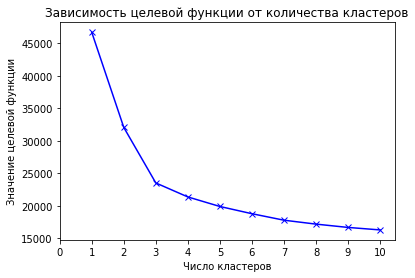

In [57]:
# список для фиксирования фунции потерь для моделей с разным количеством кластеров
distortion = []
# испытаем модели с 1-10 кластерами
K = range(1, 11)
for k in K:
    model_km = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    pipeline_clustering = Pipeline(steps=[('preprocessor', preprocessor_clustering),
                                      ('clustering_model', model_km)])
    pipeline_clustering.fit(X_train)
    distortion.append(pipeline_clustering['clustering_model'].inertia_)
# график  
plt.figure(figsize=(6, 4))
plt.plot(K, distortion, 'bx-')
plt.xticks(range(k+1))
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.title('Зависимость целевой функции от количества кластеров')
plt.show()

Выбираем 4 кластера и генерируем новый признак с помощью метода К-средних на тренировочной выборке.  
Признак относится к категориальным, поэтому сразу изменим на строковый тип.

In [58]:
# определяем модель
model_kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE)

# создаём пайплайн предобработки данных и обучения
pipeline_clustering = Pipeline(steps=[('preprocessor', preprocessor_clustering),
                                      ('clustering_model', model_kmeans)])

# проводим кластеризацию объектов, обучение на train
pipeline_clustering.fit(X_train)

# к обучающей выборке добавляем новый признак с номерами кластеров, переводим в строковый тип данных 
X_train['cluster'] = pipeline_clustering['clustering_model'].labels_

# оценим результат
X_train['cluster'].value_counts()

0    1631
2    1420
3    1131
1    1100
Name: cluster, dtype: int64

Проанализируем взаимосвязи кластеров с остальными данными в обучающей выборке

In [59]:
# корреляция Спирмена
display(pd.concat([X_train, y_train], axis=1
         ).corr(method='spearman')['cluster'].abs().to_frame().style.background_gradient(cmap='GnBu'))
# # фи-коэффициенты корреляции
# display(pd.concat([X_train, y_train], axis=1
#          ).phik_matrix()['cluster'].to_frame().style.background_gradient(cmap='GnBu'))

,cluster
monthly_charges,0.25
total_charges,0.02
tenure,0.17
number_services,0.21
cluster,1.00
churn,0.09


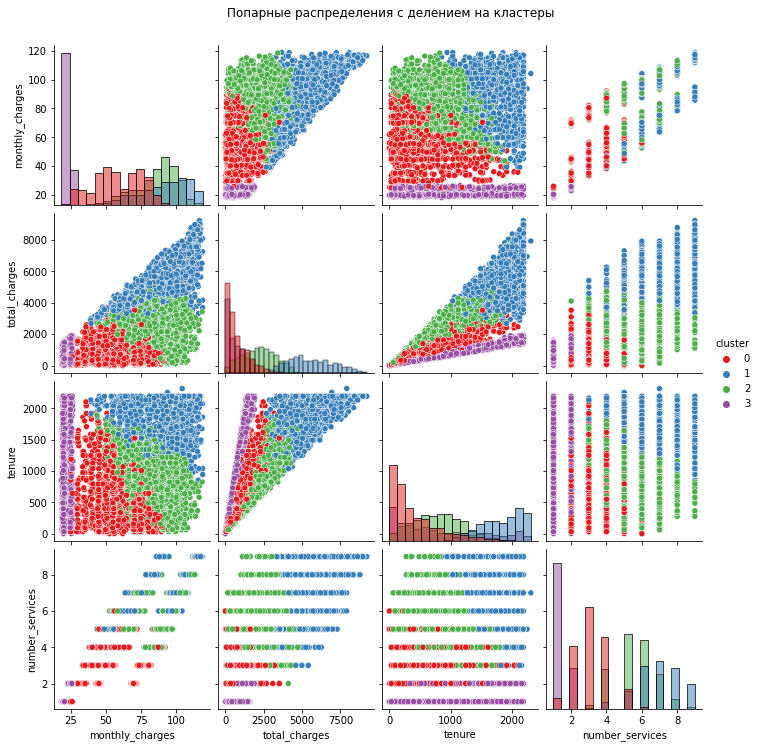

In [60]:
# проиллюстрируем кластеризацию по взаимосвязям с числовыми признаками
sns.pairplot(X_train, hue='cluster', diag_kind='hist', palette='Set1')
plt.title('Попарные распределения с делением на кластеры', x=-1, y=4.3)
plt.show()

- Линейных зависимостей не выявлено
- Видим достаточно чёткие границы разделения на кластеры в зависимости от срока обслуживания и плат

Признак с кластерами категориальный - изменим тип данных на строковый.
Сгенерируем признак в тестовой выборке

In [61]:
# меняем тип данных в трейне
X_train['cluster'] = X_train['cluster'].astype('str')

# добавляем признак с кластерами в тестовую выборку
X_test['cluster'] = pipeline_clustering.predict(X_test).astype('str')

# добавим признак в список категориальных признаков
cat_features.append('cluster')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 2074-GKOWZ to 7225-IILWY
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               5282 non-null   object 
 1   paperless_billing  5282 non-null   object 
 2   payment_method     5282 non-null   object 
 3   monthly_charges    5282 non-null   float64
 4   total_charges      5282 non-null   float64
 5   tenure             5282 non-null   int64  
 6   senior_citizen     5282 non-null   object 
 7   partner            5282 non-null   object 
 8   dependents         5282 non-null   object 
 9   internet_service   5282 non-null   object 
 10  online_security    5282 non-null   object 
 11  online_backup      5282 non-null   object 
 12  device_protection  5282 non-null   object 
 13  tech_support       5282 non-null   object 
 14  streaming_tv       5282 non-null   object 
 15  streaming_movies   5282 non-null   object 
 16  multiple_lines

---
В разделе:
- подготовлены обучающая и тестовая выборки
- выбраны признаки для обучения, составлены списки численных и категориальных признаков
- сгенерирован новый признак `cluster` с помощью кластеризации

## Моделирование  
**Исследование алгоритмов машинного обучения для решения задачи** 

Перед нами стоит задача бинарной классификации, метод обучения с учителем. Наша модель на основе характеристик клиента должна прогнозировать - уйдёт ли он (класс `1`).  
Целевой признак имеет дисбаланс - положительный класс представлен 16%. Чтобы учесть влияние дисбаланса классов при обучении попробуем настроить гиперпараметр `class_weight`.

Для оценки качества и выбора лучшей модели будем использовать метрику ROC-AUC, которая не чувствительна к дисбалансу. Необходимо построить модель, соответствующую условию: $ROC-AUC ≥ 0.85$. Дополнительно оценим Accuracy.

Подберём гиперпараметры моделей с помощью инструмента RandomizedSearchCV с предварительной предобработкой данных в Pipeline. Для каждой модели соберём свой Pipeline, где для предобработки признаков протестируем
- `StandardScaler` - для стандартизации численных признаков
- `MinMaxScaler` - для нормализации численных признаков
- `OneHotEncoder` - для преобразования категориальных признаков в неупорядоченные категории
- `OrdinalEncoder` - для преобразования категориальных признаков в упорядоченные категории
- `TargetEncoder` - для кодирования с помощью статисттик целевого признака

In [62]:
# таблица для фиксирования результатов обучения
result_table = pd.DataFrame(columns=['ROC-AUC CV', 'Accuracy CV'])
# установим количество знаков после запятой у float в таблицах
pd.set_option('display.float_format', '{:.3f}'.format)


### Baseline
В качестве точки отсчёта выберем константную модель, которая предсказывает всегда часто встречающийся класс

In [63]:
# примитивная модель, которая всегда предсказывает 0
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)

# Занесём в таблицу
result_table.loc['Baseline'] = [roc_auc_score(y_test, baseline.predict_proba(X_test)[:, 1]),
                                accuracy_score(y_test, baseline.predict(X_test))]
result_table

,ROC-AUC CV,Accuracy CV
Baseline,0.500,0.844


Так как мы имеем значительный дисбаланс классов, примитивная модель показывает высокое значение метрики Accuracy.

Будем пробовать решать задачу от простой линейной модели к более сложным.  
Приготовим функцию для обучения и подбора гиперпараметров, которая на вход будет получать пайплайн предобработки признаков и модель.

In [64]:
def randomized_search_pipeline_evaluation(preprocessing_pipeline, model, parameters):
    """Функция для подбора гиперпараметров и обучения модели на кросс-валидации с помощью RandomizedSearchCV.
    На вход принимает пайплайн с препроцессором предсказывающих признаков, модель и набор диапазонов гиперпараметров для перебора"""
    
    # зафиксируем деление на фолды с учётом дисбаланса
    kf = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
    
    # ссоздаём пайплайн предобработки данных и обучения
    pipeline = Pipeline(steps=[('preprocessor', preprocessing_pipeline),
                        ('classifier', model)])
    
    # обучение и подбор ГП в GridRandomizerCV
    randomized_search_tune = RandomizedSearchCV(pipeline, 
                                         parameters, 
                                         cv=kf, 
                                         n_iter=100,
                                         scoring=['roc_auc', 'accuracy', 'f1'], refit='roc_auc',
                                         return_train_score=True,
                                         verbose=1,
                                         n_jobs=-1, 
                                         error_score=0, # пропустить ошибку при недопустимой комбинации ГП
                                         random_state=RANDOM_STATE) 
    
    
    randomized_search_tune.fit(X_train, y_train)
    
    # значения метрик для лучшей модели
    roc_auc = randomized_search_tune.best_score_
    accuracy = randomized_search_tune.cv_results_['mean_test_accuracy'][randomized_search_tune.best_index_]
    
    index = model.__class__.__name__
    if model.__class__.__name__ in result_table.index:
        
        index = model.__class__.__name__ + '_Improved'
    
    # добавляем метрики в сводную таблицу
    result_table.loc[index, 'ROC-AUC CV'] = roc_auc
    result_table.loc[index, 'Accuracy CV'] =  accuracy

    # возвращаем обученный пайплайн с лучшей подобранной моделью и запись в таблице result_table
    return randomized_search_tune #, roc_auc, accuracy

### LogisticRegression
Предобработка данных:
- Масштабирование StandardScaler, MinMaxScaler
- Кодирование - OneHotEncoder
- Устранение мультиколлинеарности На первом этапе оставляем все признаки для обучения


In [65]:
# препроцессор для числовых и категориальных фичей
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), num_features),
        ('encoder', OneHotEncoder(drop='first'), cat_features)
    ])

# инициализация модели
model_lr = LogisticRegression()

# словарь для перебора вариантов предобработки и гиперпараметров модели
parameters_lr = {'preprocessor__scaler' : [StandardScaler(), MinMaxScaler()],
                'classifier__random_state' : [RANDOM_STATE],
                'classifier__class_weight' : ['balanced', None],
                'classifier__max_iter': [50, 100, 200, 500, 800],
                'classifier__C': np.arange(.0, 5, 0.25),
                'classifier__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
                'classifier__penalty' : [None, 'l1', 'l2', 'elasticnet']
             }

# обучение подбор ГП
model_pipe_lr = randomized_search_pipeline_evaluation(preprocessor_lr, model_lr, parameters_lr)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [66]:
# результаты подбора ГП для логисттической регрессии
display(model_lr.__class__.__name__, model_pipe_lr.best_params_, result_table)

'LogisticRegression'

{'preprocessor__scaler': StandardScaler(),
 'classifier__solver': 'newton-cg',
 'classifier__random_state': 140823,
 'classifier__penalty': 'l2',
 'classifier__max_iter': 500,
 'classifier__class_weight': None,
 'classifier__C': 0.25}

,ROC-AUC CV,Accuracy CV
Baseline,0.500,0.844
LogisticRegression,0.787,0.861


Давайте посмотрим на веса модели

In [67]:
def log_reg_coef_df(num_features=num_features):
    '''Функция для вывода таблицы с весами модели логистической регрессии'''
    
    # Получение имен столбцов после One-Hot Encoding
    try:
        all_feature_names = model_pipe_lr.best_estimator_.\
                                named_steps['preprocessor'].get_feature_names_out().tolist()
        # убираем префиксы предобработки
        all_feature_names = [re.sub(r".*__", "", col) for col in all_feature_names]
    except:
        all_feature_names = num_features + model_pipe_lr.best_estimator_.\
                            named_steps['preprocessor'].named_transformers_['encoder'].\
                        get_feature_names(cat_features).tolist()

    # Получение коэффициентов модели
    model_coefs = model_pipe_lr.best_estimator_.steps[1][1].coef_
    model_coefs = model_coefs.reshape(model_coefs.shape[1])

    # Создание DataFrame с именами признаков и соответствующими коэффициентами
    coef_df = pd.DataFrame(abs(model_coefs) * 10, index=all_feature_names, columns=['Feature importance'])

    return coef_df.sort_values(by='Feature importance', ascending=False).style.background_gradient()

log_reg_coef_df()

,Feature importance
type_Two year,16.93
type_One year,13.02
payment_method_Mailed check,8.56
partner_Yes,7.81
cluster_2,6.37
multiple_lines_Yes,5.88
total_charges,5.72
online_backup_Yes,5.56
multiple_lines_No service,4.73
internet_service_Fiber optic,4.60


1) Модель низко оценила важность ключевых признаков tenure и monthly_charges. Это может свидетельствовать о негативном влиянии мультиколлинеарности предсказывающих признаков. Еще раз взглянем на корреляцию.

2) После кодирования с удалением первых столбцов признаков с услугами образовалось несколько столбцов с абсолютно одинаковыми значениями - 'No service'. Модель оценила их важность одинаково. Попробуем вместо первого удалить именно эти столбцы


In [68]:
X_train.corr().style.background_gradient()

,monthly_charges,total_charges,tenure,number_services
monthly_charges,1.00,0.63,0.23,0.85
total_charges,0.63,1.00,0.82,0.75
tenure,0.23,0.82,1.00,0.43
number_services,0.85,0.75,0.43,1.00


Давайте удалим признаки `number_services` и `total_charges`, а также категориальный `cluster`, который значительно опирается на предедущих два, и посмотрим на результат обучения

In [69]:
# новые списки численных и категориальных признаков специально для логистической регрессии
num_features_lr = [col for col in num_features if col not in [ 'number_services', 'total_charges']]
cat_features_lr = [col for col in cat_features if col not in [ 'cluster'] + services_list]
# отдельно список с услугами
services_list.remove('phone')

# новый препроцессор:
# - не добавит в обучающий датасет удаленные из списков признаки
# - второе кодирование для признаков с услугами - удаляем третий столбец
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), num_features_lr),
        ('encoder', OneHotEncoder(drop='first'), cat_features_lr ),
        ('encoder_services', OneHotEncoder(drop=8*['No service']), services_list) # в дроп список с 8 "No service"
    ])

# обучение подбор ГП
model_pipe_lr = randomized_search_pipeline_evaluation(preprocessor_lr, model_lr, parameters_lr)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [70]:
# результаты подбора ГП для логисттической регрессии
display(model_lr.__class__.__name__, model_pipe_lr.best_params_, result_table)

'LogisticRegression'

{'preprocessor__scaler': MinMaxScaler(),
 'classifier__solver': 'lbfgs',
 'classifier__random_state': 140823,
 'classifier__penalty': 'l2',
 'classifier__max_iter': 200,
 'classifier__class_weight': None,
 'classifier__C': 0.25}

,ROC-AUC CV,Accuracy CV
Baseline,0.500,0.844
LogisticRegression,0.787,0.861
LogisticRegression_Improved,0.768,0.861


In [71]:
# чтобы работало в JupyterHub
# Получение имен столбцов после One-Hot Encoding
try:
    all_feature_names = model_pipe_lr.best_estimator_.\
                            named_steps['preprocessor'].get_feature_names_out().tolist()
    # убираем префиксы предобработки
    all_feature_names = [re.sub(r".*__", "", col) for col in all_feature_names]

except:
    all_feature_names = num_features_lr + model_pipe_lr.best_estimator_.\
                        named_steps['preprocessor'].named_transformers_['encoder'].\
                    get_feature_names(cat_features_lr).tolist() + model_pipe_lr.best_estimator_.\
                        named_steps['preprocessor'].named_transformers_['encoder_services'].\
                    get_feature_names(services_list).tolist()
    

# Получение коэффициентов модели
model_coefs = model_pipe_lr.best_estimator_.steps[1][1].coef_
model_coefs = model_coefs.reshape(model_coefs.shape[1])

# Создание DataFrame с именами признаков и соответствующими коэффициентами
coef_df = pd.DataFrame(abs(model_coefs) * 10, index=all_feature_names, columns=['Feature importance'])

coef_df.sort_values(by='Feature importance', ascending=False).style.background_gradient()

,Feature importance
tenure,28.18
type_Two year,14.24
type_One year,11.77
payment_method_Mailed check,9.38
partner_Yes,7.71
multiple_lines_No,4.47
online_backup_Yes,3.88
payment_method_Electronic check,3.84
multiple_lines_Yes,3.27
senior_citizen_Yes,2.73


Признак `tenure` теперь играет главную роль в предсказании, но увеличить метрики не удалось - результат обучения не удовлетворяет нашим условиям. Попробуем непараметрические алгоритмы.

### RandomForestClassifier
Для предобработки данных попробуем использовать:
- Масштабирование: StandardScaler, MinMaxScaler, без масштабирования
- Кодирование: порядковое OrdinalEncoder, на основе статистик целевой переменной TargetEncoder, без кодирования

In [72]:
# комбинированный препроцессор для числовых и категориальных переменных
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), num_features),
        ('encoder', OrdinalEncoder(), cat_features)
    ])

# определяем модель случайного леса
model_rf = RandomForestClassifier()

# словарь для перебора вариантов предобработки и гиперпараметров модели
parameters_rf = {'preprocessor__scaler' : [StandardScaler(), MinMaxScaler(), 'passthrough'],
                 'preprocessor__encoder' : [OrdinalEncoder(), TargetEncoder(smoothing=0.2), 'passthrough'],
                'classifier__random_state' : [RANDOM_STATE],
                'classifier__class_weight' : ['balanced', None],
                'classifier__n_estimators': [100, 200, 300, 500],
                'classifier__max_depth': [None] + list(range(3, 10, 2)),
                'classifier__criterion': ['gini', 'entropy'],
#                  'classifier__max_features': ['sqrt', 'log2'],
                 'classifier__bootstrap' : [True, False]
             }

# обучение и подбор ГП
model_pipe_rf = randomized_search_pipeline_evaluation(preprocessor_rf, model_rf, parameters_rf)

# результаты подбора ГП для логисттической регрессии
display(model_rf.__class__.__name__, model_pipe_rf.best_params_, result_table)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


'RandomForestClassifier'

{'preprocessor__scaler': MinMaxScaler(),
 'preprocessor__encoder': TargetEncoder(smoothing=0.2),
 'classifier__random_state': 140823,
 'classifier__n_estimators': 300,
 'classifier__max_depth': 9,
 'classifier__criterion': 'entropy',
 'classifier__class_weight': None,
 'classifier__bootstrap': True}

,ROC-AUC CV,Accuracy CV
Baseline,0.500,0.844
LogisticRegression,0.787,0.861
LogisticRegression_Improved,0.768,0.861
RandomForestClassifier,0.837,0.863


Случайный лес значительно лучше справляется с задачей предсказания, но результат на кросс-валидации не удовлетворяет поставленным условиям.  
Далее попробуем новый для нас алгоритм и добавим в случайный лес еще больше случайности.

#### ExtraTreesClassifier
Предобработка и набор гиперпараметров аналогичные случайному лесу

In [73]:
# модель
model_et = ExtraTreesClassifier()
# обучение
model_pipe_et = randomized_search_pipeline_evaluation(preprocessor_rf, model_et, parameters_rf)

# результаты подбора
display(model_et.__class__.__name__, model_pipe_et.best_params_, result_table)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


'ExtraTreesClassifier'

{'preprocessor__scaler': MinMaxScaler(),
 'preprocessor__encoder': TargetEncoder(smoothing=0.2),
 'classifier__random_state': 140823,
 'classifier__n_estimators': 300,
 'classifier__max_depth': 9,
 'classifier__criterion': 'entropy',
 'classifier__class_weight': None,
 'classifier__bootstrap': True}

,ROC-AUC CV,Accuracy CV
Baseline,0.500,0.844
LogisticRegression,0.787,0.861
LogisticRegression_Improved,0.768,0.861
RandomForestClassifier,0.837,0.863
ExtraTreesClassifier,0.824,0.862


Результат ExtraTreesClassifier хуже RandomForesClassifier и соответственно ниже требуемого.  
Попробуем градиентный бустинг.

### CatBoostClassifier
Для предобработки данных попробуем использовать:
- Масштабирование: StandardScaler или без масштабирования
- Кодирование: порядковое OrdinalEncoder, на основе статистик целевой переменной TargetEncoder, без кодирования

In [74]:
# комбинированный препроцессор для числовых и категориальных переменных
preprocessor_cb = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), num_features),
        ('encoder', OrdinalEncoder(), cat_features)
    ])

# модель
model_cb = cb.CatBoostClassifier(silent=True)

# словарь для перебора вариантов предобработки и гиперпараметров модели
parameters_cb = {'preprocessor__scaler' : [StandardScaler(), 'passthrough'],
                'preprocessor__encoder' : [OrdinalEncoder(), TargetEncoder(smoothing=0.2), 'passthrough'],
                'classifier__random_state' : [RANDOM_STATE],
                'classifier__auto_class_weights' : ['Balanced', None],
                'classifier__iterations': [100, 200, 300, 500, 800],
                'classifier__depth': [None] + list(range(2, 9, 2)),
                'classifier__learning_rate': np.arange(.0, 1, 0.05),
             }
# подбор и обучение
model_pipe_cb = randomized_search_pipeline_evaluation(preprocessor_cb, model_cb, parameters_cb)

# результаты подбора
display(model_cb.__class__.__name__, model_pipe_cb.best_params_, result_table)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


'CatBoostClassifier'

{'preprocessor__scaler': StandardScaler(),
 'preprocessor__encoder': OrdinalEncoder(),
 'classifier__random_state': 140823,
 'classifier__learning_rate': 0.6000000000000001,
 'classifier__iterations': 500,
 'classifier__depth': 2,
 'classifier__auto_class_weights': 'Balanced'}

,ROC-AUC CV,Accuracy CV
Baseline,0.500,0.844
LogisticRegression,0.787,0.861
LogisticRegression_Improved,0.768,0.861
RandomForestClassifier,0.837,0.863
ExtraTreesClassifier,0.824,0.862
CatBoostClassifier,0.918,0.891


Градиентный бустинг CatBoost показывает значительно более высокие метрики ROC-AUC и Accuracy, значения удовлетворяют условиям.

---

Для решения задачи бинарной классификации протестированы 3 алгоритма машинного обучения: LogisticRegression, RandomForestClassifier (+ExtraTreesClassifier), CatBoostClassifier с разными способами предобработки численных и категориальных признаков.

В качестве лучшей модели выбран градиентный бустинг CatBoost с предобработкой данных StandardScaler, OrdinalEncoder.  
Далее протестируем модель на новых данных и проанализируем, как мы можем ее улучшить.

## Тестирование лучшей модели и анализ результатов
Оценим работу модели на новых данных - тестовом выборке.  
Наш KPI : *ROC-AUC ≥ 0.85 на тестовой выборке*

In [75]:
# испытание на тестовой выборке
#  вероятности для положительного класса
y_score_test = model_pipe_cb.predict_proba(X_test)[:, 1]
# добавим в таблицу результат метрик на тестовой выборке
result_table.loc['CatBoostClassifier', 'ROC-AUC test'] = roc_auc_score(y_test, y_score_test)
result_table.loc['CatBoostClassifier', 'Accuracy test'] = accuracy_score(y_test, model_pipe_cb.predict(X_test))

result_table.style.highlight_null(null_color='black').set_precision(2)

,ROC-AUC CV,Accuracy CV,ROC-AUC test,Accuracy test
Baseline,0.50,0.84,nan,nan
LogisticRegression,0.79,0.86,nan,nan
LogisticRegression_Improved,0.77,0.86,nan,nan
RandomForestClassifier,0.84,0.86,nan,nan
ExtraTreesClassifier,0.82,0.86,nan,nan
CatBoostClassifier,0.92,0.89,0.93,0.89


Модель отлично справилась с новыми данными, получив высокое значение метрики ROC-AUC. Проанализируем работу модели подробней.

Визуализируем и сравним **ROC-кривые** для обучающей и тренировочной выборки

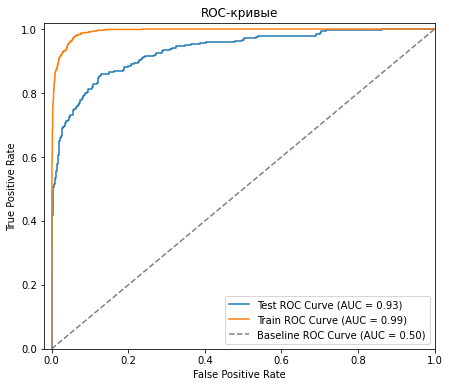

In [76]:
# рок кривая для тестовой и обучающей выборок
fpr_test, tpr_test, thresholds = roc_curve(y_test, y_score_test)
y_score_train = model_pipe_cb.predict_proba(X_train)[:, 1] #использовать cross_val_predict
fpr_train, tpr_train, thresholds2 = roc_curve(y_train, y_score_train)

plt.figure(figsize=(7, 6))
# графики рок-кривых
plt.plot(fpr_test, tpr_test, label='Test ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_score_test)))
plt.plot(fpr_train, tpr_train, label='Train ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_train, y_score_train)))
# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Baseline ROC Curve (AUC = 0.50)')

plt.xlim(-0.02, 1)
plt.ylim(0, 1.02)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
plt.legend(loc='lower right')
plt.show()

Метрика ROC-AUC на тестовой выборке ниже на 6%,чем на обучающей, что может быть признаком переобучения. Но модель обладает достаточной  обобщающей способностью и хорошо различает классы. В данных условиях степень переобучения выглядит незначительной.  
Посмотрим подробней на матрице ошибок

<b> Confusion Matrix </b>

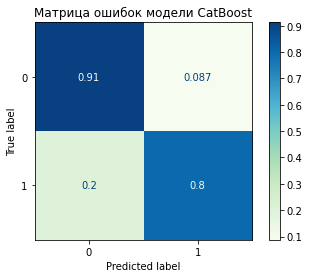

In [77]:
# построим Confusion Matrix, отображение в долях
plot_confusion_matrix(model_pipe_cb.best_estimator_, X_test, y_test, normalize='true', cmap='GnBu')
plt.title('Матрица ошибок модели CatBoost')
plt.show()

Модель CatBoost ошибается в предсказании положительного класса (клиент уйдёт) в 20% и более точна в предсказании отрицательного (клиент останется) 91%.

Зафиксируем F1-меру - баланс между точностью и полнотой

In [78]:
print('F1-мера =', round(f1_score(y_test, model_pipe_cb.predict(X_test)), 3))

F1-мера = 0.704


Есть куда улучшаться.

---
Выбранная модель CatBoostClassifier показала высокие результаты при тестировании:
- ROC-AUC = 0.93  - соостветствует поставленному KPI
- Есть переобучение, но обобщающая способность  достаточно высокая
- Ошибка в предсказании положительного класса (клиент уйдёт) - 20% и отрицательного (клиент останется) - 9%.

### Важность признаков моделей, интерпретация
Посмотрим как модель CatBoost и дополнительно RandomForestClassifier определяют важность признаков

In [79]:
def feature_importance_table(model, increase=1):
    '''Функция для вывода важности признаков из моделей градиентный бустинг и случайного леса.
    На вход принимает модель, полученную подбором и обучением на кросс-валидации'''
    # названия признаков
    try:
        all_feature_names = model.best_estimator_.named_steps['preprocessor'].get_feature_names_out().tolist()
        all_feature_names = [re.sub(r".*__", "", col) for col in all_feature_names]
    
    except:
        all_feature_names = num_features + cat_features

    # Получение значений важности
    model_coefs = model.best_estimator_.steps[1][1].feature_importances_

    # Создание DataFrame с именами признаков и соответствующими коэффициентами
    importance_table = pd.DataFrame(model_coefs*increase, index=all_feature_names, columns=['Feature importance'])

    return importance_table.sort_values(by='Feature importance', ascending=False).style.background_gradient()

In [80]:
# таблица важности признаков для catboost
styled_fi_table_cb = feature_importance_table(model_pipe_cb
                        ).set_table_attributes("style='display:inline'").set_caption('CatBoostClassifier')
# таблица важности признаков для randomforest
styled_fi_table_rf =  feature_importance_table(model_pipe_rf, 100
                        ).set_table_attributes("style='display:inline'").set_caption('RandomForestClassifier')

# отображение рядом
display_html(styled_fi_table_cb._repr_html_()+styled_fi_table_rf._repr_html_(), raw=True)


,Feature importance
tenure,71.20
total_charges,8.91
monthly_charges,8.00
number_services,3.45
type,2.49
partner,1.41
payment_method,1.06
multiple_lines,0.66
cluster,0.37
online_backup,0.34


Ключевой признак для предсказания ухода клиентся является `tenure` срок обслуживания. Дополняющие - полная и ежемесячная трата `monthly_charges`, `total_charges`, количество услуг `number_services`, тип оплаты `type`. В случайном лесе распределение важности между признаками более равномерное.

Теперь попробуем интерпретировать важность признаков с помощью библиотеки SHAP

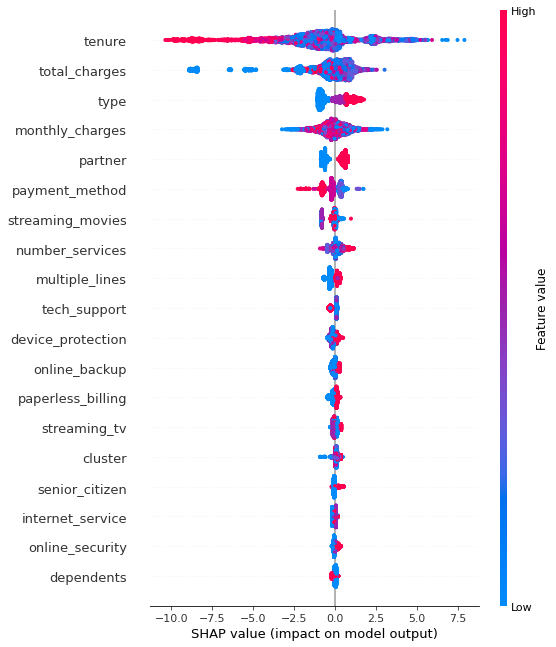

In [81]:
# # подготовим датасет для анализа shap
# предобработка признаков
X_shap = model_pipe_cb.best_estimator_[0].transform(X_train)
X_shap = pd.DataFrame(X_shap, columns=num_features + cat_features)

# график важности признаков
explainer = shap.TreeExplainer(model_pipe_cb.best_estimator_[1])
shap_value = explainer.shap_values(X_shap)
shap.summary_plot(shap_value, X_shap, max_display=25, auto_size_plot=True)


*Подсказка для интерпретации SHAP:*
- *распределение уходит влево от центральной вертикальной линии — описывает negative класс (0 - клиент останется), вправо — positive (1 - клиент уйдёт)*
- *красный - высокие значения признака, синий - низкие значения признака*
- *чем больше дисперсия у точки, тем больший вклад дал признак в предсказание*
- *по одну сторону красные, по другую синие точки - признак точно делит*


In [82]:
# расшифровка кодирования OrdinalEncoder
# порядок задавался порядком появлению в датасете
list_encode = {}
encoding_map = {}
# для каждого категориального признака создать словарь с уникальными значениями и порядковым номером
for col in cat_features:
    encoding_map = {}
    for idx, value in enumerate(X_train[col].unique()):
        encoding_map[idx] = value
        list_encode[col] = encoding_map
print('Расшифровка OrdinalEncoder:')
pd.DataFrame(list_encode)

Расшифровка OrdinalEncoder:


,type,paperless_billing,payment_method,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,cluster
0,Month-to-month,Yes,Bank transfer (automatic),No,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,No,2
1,One year,No,Credit card (automatic),Yes,No,No,No service,No service,No service,No service,No service,No service,No service,Yes,3
2,Two year,NaN,Mailed check,NaN,NaN,NaN,DSL,Yes,Yes,Yes,Yes,No,No,No service,1
3,NaN,NaN,Electronic check,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0



- Наибольший вклад в предсказание обоих классов даёт признак `tenure`. Высокие значения признака характеризуют negative класс (0 - клиент останется), а низкие - positive (1 - клиент уйдёт). Большее влияние  - на предсказание остающихся клиентов.
- Далее по влиянию  `total_charges`: сильное влияние низких значений признака на предсказание класса 0 
- `type` имеет менее значительный вклад с чётким разделением: 
    - Month-to-month - класс 0,
    - Two year - класс 1, 
    - One year - между
- `partner` наличие партнёра имеет небольшое влияние, но чёткое разделение: 
    - 'Yes' (синее) - класс 0, 
    - 'No' (красное) - класс 1
- `payment_method` также с небольшим но достаточно чётким влиянием:
    - Electronic check	- класс 0
    - Mailed check - класс 0 меньше влияние, чем у Electronic check
    - automatic Bank transfer / Credit card - класс 1
- `senior_sitizen` вклад в предсказание маленький, но выражено смещение в класс 1 (клиент уйдёт)



Проведённый анализ может быть использован в качестве подствечивания тонких мест для бизнеса и **рекомендаций для улучшения**:
- Проанализировать соответствие стоимости услуг рыночной, так как уходят клиенты с высокими ежемесячными платами
- Так как клиенты склонны уходить через 1-2 года, можно разработать систему лояльности с зависимостью от срока обслуживания.
- Проанализировать качество интернет-подключения Optic Fiber, возможно, нестабильное качество или ниже, чем у конкурентов, завышенная цена.
- Пересмотреть условия контракта с годовыми типами оплаты, возможно очевидная невыгодность их приобретения.
- Подготовить / пересмотреть условия специальных предложений для пенсионеров, семейные пакеты.
- Проанализировать качество и удобство выполнения онлайн-платежей, так как склонны к уходу пользователи с автоматическим списанием средств.

---------


## Выводы и резюме

Перед нами была поставлена задача разработать модель машинного обучения для предсказания ухода пользователя телеком-услугами по его характеристикам, чтобы компания-провайдер могла принять предупреждающие меры.

Для исследования предоставлены исторические данные: 4 датасета с информацией о контрактах, персональных данных, интернет услугах и телефонии. Данные полные и чистые без дубликатов и пропусков.

Датасеты были объеденены в одну таблицу, в сумме получили 7043 записи с уникальными идентификаторами клиентов и 19 характеристиками. Так как часть клиентов использует только услуги телефонии или только интернет-услуги, при объединении мы получили пропуски, которые были заполнены выражением "*No servise*".   
В признаке с полными затратами `tota_charges`  потребовалось заменит пустые значения на нули - это клиенты, только заключившие контракт.

Дополнительно сгенерированы **новые признаки** на основе имеющихся данных:
- Целевой бинарный признак уход клиента `churn` создан на основе даты расторжения контракта `end_date`: 1 - дата есть, 0 - дата не указана.
-  Срок обслуживания `tenure` - разница между датой открытия и закрытия контракта. Если даты закрытия нет, то использовали последнюю дату 2020-02-01
- Наличие услуги телефонии `phone` - использовали только для удобства EDA
- Количество подключенных услуг `number_services` 
- Проведена кластеризация алгоритмом KMeans на тренировочной выборке, в результате которой получен новый признак `cluster`, делящий все объекты на 4 кластера. В основном алгоритм приделении опирался на срок обслуживания и суммы затрат клиентов. В итоге показал низкое влияние на предсказание моделей машинного обучения.  

**Исследовательский анализ** показал, что данные собраны за 6 лет (2314 дней) в периоде 10.2013 - 01.2020 - предположительно, с момента появления компании / услуг.  Есть клиенты, пользующиеся услугами на протяжении всего периода. В 2019 году значительный рост новых клиентов. Отток клиентов равномерно медленно растёт на протяжении всего периода, начиная с 06.2014.  

Выявлена высокая линейная зависимость между месячными тратами и количеством услуг, между полной тратой и продолжительностью обслуживания, между обоими тратами. Нам пришлось учесть эту мультиколлинеарность при обучении логистической регрессии.  

Большинство признаков датасете категориальные, для анализа взаимосвязей мы применили коэффициенты корреляции фи:    
- Это показало, что все интернет-услуги высоко коррелируют между собой, а также с месячной платой - скорее всего, чаще берутся пакетом.   
- Нашли интересную зависимость типов оплаты с датой заключения контрактов и количеством услуг. Последующий анализ показал, что в начале заключались в основном годовые контракты, что постепенно изменилось на противоположное в течение всего периода - сейчас клиенты в основном выбирают ежемесячную оплату.   
- Уход клиента наиболее коррелирует с продолжительностью обслуживания и тратами.  

Результатом EDA стал **портрет ушедшего клиента**:
- Срок обслуживания `tenure` 1 - 4.7 лет
- Относительно высокая ежемесячная плата `monthly_charges`
- Клиент предпочитает использовать передовые технологии и комфортное обслуживание:
    - интернет-подключение Fiber Optic `internet_service`
    - сразу пакет услуг, наиболее критично 7-9 услуг сразу `number_services`
    - безналичная оплата `paperless_billing`
    - автоматическое списание с банковского счёта или кредитной карты `paymen_method`
    - Контракт с годовыми типами оплаты `type`
- Персональные характеристики: состоит в браке, имеет иждивенцев, пенсионер, любого пола.

После \~4,7 лет (~1600 дней) обслуживания и, как следствие, при достижении ~7 тыс. у.е. полных трат уход клиента в данных показан как наиболее маловероятный.  

**Моделирование**

Решалась задача бинарной классификации. В целевом признаке с уходом клиента `churn` два класса представлены неравномерно - 16% от всех пользователей когда-то перестало пользоваться услугами компании. Дисбаланс учитывался с помощью настройки гиперпарамтра моделей class_balanced.

Для моделирования датасет разделён на обучающую 75% и тестовую 25% выборки. Для всех аллгоритмов установлен `random_state`=140823.  
Обучение, валидация, подбор гиперпараметров, а также способа масштабирования и кодирования проводились в RandomizedSearchCV кросс-валидацией на тренировочной выборке.   

Для выбора лучшей модели взяли метрику ROC-AUC, которая не чувствительна к дисбалансу, дополнительно оценивали Accuracy. Заказчиком установлено требование добиться ROC-AUC ≥ 0.85.

Исследовано 4 алгоритма ML: 
- `LogisticRegression` - показала низкий результат
- `RandomForestClassifier` и `ExtraTreesClassifier` - показали себя значительно лучше, но не дали нужного уровня качества
- Градиентный бустинг `CatBoostClassifier` - дал высокий удовлетворительный результат, **выбран лучшей моделью** для решения задачи


In [120]:
display('Таблица результатов обучения:', result_table.style.highlight_null(null_color='black').set_precision(2))
display('Pipeline лучшей модели:', model_pipe_cb.best_estimator_,
        'Гиперпараметры модели CatBoostClassifier:', model_pipe_cb.best_params_,
      # 'Предсказывающие признаки:', list(model_pipe_cb.feature_names_in_) # не работает на сервере, нет альтернатив
       )

'Таблица результатов обучения:'

,ROC-AUC CV,Accuracy CV,ROC-AUC test,Accuracy test
Baseline,0.50,0.84,nan,nan
LogisticRegression,0.79,0.86,nan,nan
LogisticRegression_Improved,0.77,0.86,nan,nan
RandomForestClassifier,0.84,0.86,nan,nan
ExtraTreesClassifier,0.82,0.86,nan,nan
CatBoostClassifier,0.92,0.89,0.93,0.89


'Pipeline лучшей модели:'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['monthly_charges',
                                                   'total_charges', 'tenure',
                                                   'number_services']),
                                                 ('encoder', OrdinalEncoder(),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'dependents',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
               

'Гиперпараметры модели CatBoostClassifier:'

{'preprocessor__scaler': StandardScaler(),
 'preprocessor__encoder': OrdinalEncoder(),
 'classifier__random_state': 140823,
 'classifier__learning_rate': 0.6000000000000001,
 'classifier__iterations': 500,
 'classifier__depth': 2,
 'classifier__auto_class_weights': 'Balanced'}

Список предсказывающих признаков:  
`type`, `paperless_billing`, `payment_method`, `monthly_charges`, `total_charges`, `tenure`, `senior_citizen`, `partner`, `dependents`, `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies`, `multiple_lines`, `number_services`, `cluster`

Выбранная **модель CatBoostClassifier** показала высокие **результаты** при тестировании:
- ROC-AUC = 0.93  - соостветствует поставленному KPI
- Есть переобучение, но обобщающая способность  достаточно высокая
- Ошибка в предсказании положительного класса (клиент уйдёт) - 20% и отрицательного (клиент останется) - 9%.

**Анализ важности признаков модели** и их интерпретация показали:
- Ключевой признак для предсказания ухода клиентся является `tenure` срок обслуживания. 
- Дополняющие признаки - полная и ежемесячная трата `monthly_charges`, `total_charges`,  тип оплаты `type`
- Менее важные, но с интерпретируемым влиянием на классы:  количество услуг `number_services`, способ оплаты `payment_method` , наличие партнёра `partner`, наличие пенсионного статуса `senior_sitizen`.

Проведённый анализ может быть использован в качестве подствечивания тонких мест для бизнеса и **рекомендаций для улучшения**:
- Проанализировать соответствие стоимости услуг рыночной, так как уходят клиенты с высокими ежемесячными платами
- Так как клиенты склонны уходить через 1-2 года, можно разработать систему лояльности с зависимостью от срока обслуживания.
- Проанализировать качество интернет-подключения Optic Fiber, возможно, нестабильное качество или ниже, чем у конкурентов, завышенная цена.
- Пересмотреть условия контракта с годовыми типами оплаты, возможно очевидная невыгодность их приобретения.
- Подготовить / пересмотреть условия специальных предложений для пенсионеров, семейные пакеты.
- Проанализировать качество и удобство выполнения онлайн-платежей, так как склонны к уходу пользователи с автоматическим списанием средств.

**Рефлексия**

В целом проект выполнен по задуманному плану, за исключением нескольких **дополнений**:
- В процессе EDA появилась идея создать признак с количеством признаков
- Проведена кластеризация также для создания признака на основании последней изученной темы
- Введена сразу Baseline и с ней сравнивались все модели, а не только последняя на тесте
- Кодирование и масштабирование признаков также подбиралось в RandomizedSearchCV, а не делалось предварительно
- Для удобства анализа доблено изменение численного типа данных категориального признака о senior_sitizen для удобства анализа и сборки пайплайна
- Добавлена интерпретация важности признаков с помощью библиотеки SHAP

**Затруднения**:
- Из-за пустых значений в total_charges и невозможности сразу изменить тип данных знакомство с признаками из раздела перенеслось в EDA.
- Не получилось оперативно освоить статистику хи-квадрат и корреляцию Крамера, вместо решено было использовать уже проверенные фи-коэффициенты
- Осталась неудовлеттворённость по отбору признаков, не хватило времени поэкспериментировать

**Ключевым шагом** для достижения высокой метрики ROC-AUC стало создание признака с длительностью обслуживания `tenure`, который вносит основной вклад в предсказание. Достаточна комбинация с градиентным бустингом даже без подбора гиперпараметров и компенсации дисбаланса классов